In [145]:
#import modules
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
import umap
import copy

In [146]:
#load the data and subset only the required columns
basepath = "C:/Users/ashuk/Desktop/MLProject/ashrae-energy-prediction/"
train = pd.read_csv(basepath + "train.csv")
building = pd.read_csv(basepath + "building_metadata.csv")
train = pd.merge(train, building, left_on="building_id", right_on="building_id", how="left")
train = train[['building_id','timestamp', 'meter', 'meter_reading', 'primary_use']]
del building

## Section for some custom functions that are to be used frequently.

In [147]:
color_values = ["red", "green","brown","purple","cyan"]
def plot_tsne(X,pivot=None, alpha=0.6, xlabel="x-axis", ylabel="y-axis", title="Dimension reduced by t-SNE"):
    plt.figure(figsize=(20,10))
    tsne = TSNE()
    results_tsne = tsne.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(results_tsne[:,0], results_tsne[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
    )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return
def plot_isomap(X,pivot=None, alpha=0.6, neighbor = 8, dimension=2, xlabel="x-axis", ylabel="y-axis", title="Dimension reduced by ISOMAP"):
    plt.figure(figsize=(20,10))
    isomap = Isomap(n_components=dimension, n_neighbors=neighbor)
    results_isomap = isomap.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(results_isomap[:,0], results_isomap[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
        )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return
def plot_umap(X,pivot=None, neighbor = 8, dimension=2, alpha=0.6, xlabel="x-axis", ylabel="y-axis", title="Dimension reduced by UMAP"):
    plt.figure(figsize=(20,10))
    reducer = umap.UMAP(n_neighbors=neighbor, n_components=dimension)
    umap_result = reducer.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(umap_result[:,0], umap_result[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
        )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return

def plot_kernel_pca(X, pivot=None, kernel="rbf", esolver="auto", rzev = True, g = 15, deg = None, title="Representation obtained usinf Kernel PCA"):
    plt.figure(figsize=(20,10))
    if deg is not None:
        kpca = KernelPCA(n_components=2, n_jobs=-1, eigen_solver=esolver, remove_zero_eig=rzev, gamma=g, kernel=kernel, degree=deg)
    else:
        kpca = KernelPCA(n_components=2, n_jobs=-1, eigen_solver=esolver, remove_zero_eig=rzev, gamma=g, kernel=kernel)
    
    kpca_result = kpca.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(kpca_result[:,0], kpca_result[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
        )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return

In [148]:
def perform_clustering_quarter_wise(quarter_no=1, train = None, drop_columns=None):
    
    quarter1 = copy.deepcopy(train)
    if quarter_no>0:
        quarter1["quarter"] = quarter1["timestamp"].dt.quarter
        quarter1 = quarter1[quarter1["quarter"]==quarter_no]
    quarter1["meter_reading"].fillna(0, inplace=True)
    
    if quarter_no>0:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    else:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot(values="meter_reading", index="building_id", columns="timestamp")
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    #perHourElectricityConsumptionEachBuildingQ1.drop(perHourElectricityConsumptionEachBuildingQ1.index[[1100,779,1198,1089,1022,1169,1160,1149,1285]], inplace=True)
    perHourElectricityConsumptionEachBuildingQ1.head(5)
    if drop_columns is not None:
        perHourElectricityConsumptionEachBuildingQ1.drop(perHourElectricityConsumptionEachBuildingQ1.index[drop_columns], inplace=True)
    
    XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuildingQ1.values.copy())
    XQ1
    
    silhouette_scores_q1 = list()
    inertia = list()
    no_cluster = np.arange(2,28).astype("int")
    for cluster in no_cluster:
        kmeansQ1 = KMeans(n_clusters=cluster, init="k-means++")
        c_f = kmeansQ1.fit_predict(XQ1)
        silhouette_scores_q1.append(silhouette_score(XQ1, kmeansQ1.labels_))
        inertia.append(kmeansQ1.inertia_)
    
    
    plt.figure(figsize=(20,10))
    plt.plot([i for i in range(0,26,1)], silhouette_scores_q1)
    plt.xticks([i for i in range(0,26,1)])
    plt.yticks(np.arange(0,1,0.1))
    plt.ylabel("silhouette score")
    plt.xlabel("cluster number")
    plt.grid()
    
    plt.figure(figsize=(20,10))
    plt.plot([i for i in range(1,27,1)], inertia)
    plt.xticks([i for i in range(1,27,1)])
    plt.ylabel("within cluster SSE")
    plt.xlabel("cluster number")
    plt.grid()
    kmeans = KMeans(n_clusters=3)
    cluster_found_q1 = kmeans.fit_predict(XQ1)
    cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
    perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)

    plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor=10, title="KMeans with euclidean distance")
    
    perHourElectricityConsumptionEachBuildingQ1.index = perHourElectricityConsumptionEachBuildingQ1.index.droplevel(-1)
    kmeansTslearn = TimeSeriesKMeans(n_clusters=3, max_iter=1000, metric="dtw", n_jobs=4, init="k-means++")
    cluster_found_q1 = kmeansTslearn.fit_predict(XQ1)
    cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
    perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)
    
    plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor = 10, title="KMeans with DTW distance")
    
    # printing the score of internal validation measures
    print("Internal Validation scores for quarter {}".format(quarter_no))
    print("silhouette score on euclidean metric: ",silhouette_score(XQ1, kmeans.labels_))
    print("silhouette score on dtw metric: ",silhouette_score(XQ1, kmeansTslearn.labels_))
    print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, kmeans.labels_))
    print("calsinki-H score on dtw metric: ",calinski_harabasz_score(XQ1, kmeansTslearn.labels_))
    print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, kmeans.labels_))
    print("davis-B score on dtw metric: ",davies_bouldin_score(XQ1, kmeansTslearn.labels_))
    return

### Extract only the meter readings for electricity (meter_type = 1)

In [149]:
train = train.loc[train["meter"]==3]

In [150]:
train = train[~train["building_id"].isin([1100,779,1198,1089,1022,1169,1160,1149,1285,1021])]

In [151]:
#convert timestamp in strin to type timestamp and set it as index of the dataframe.
train["timestamp"] = pd.to_datetime(train["timestamp"])
train.set_index(["timestamp"], inplace=True)

In [152]:
#check the shape of the extracted dataframe
print(train.shape)

(1246488, 4)


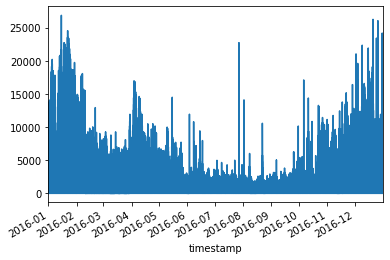

In [153]:
# simple plot  of meter readings over the whole year
train.loc[:, "meter_reading"].plot()

In [154]:
# summarizing electricity consumption over the whole year according to timestamp
summaryTimestampData = train.groupby([ "primary_use","timestamp"])["meter_reading"].agg("mean").reset_index()
summaryTimestampData.set_index(["primary_use"], inplace=True)
summaryTimestampData.set_index(["timestamp"], append=True, inplace=True)
summaryTimestampData

meter_reading
primary_use        timestamp                         
Education          2016-01-01 00:00:00     495.987571
                   2016-01-01 01:00:00     520.900561
                   2016-01-01 02:00:00     618.545726
                   2016-01-01 03:00:00     552.486440
                   2016-01-01 04:00:00     553.645712
...                                               ...
Technology/science 2016-12-31 19:00:00     483.570000
                   2016-12-31 20:00:00       0.000000
                   2016-12-31 21:00:00       0.000000
                   2016-12-31 22:00:00     425.064000
                   2016-12-31 23:00:00       0.000000

[70262 rows x 1 columns]

Text(0, 0.5, 'mean meter reading')

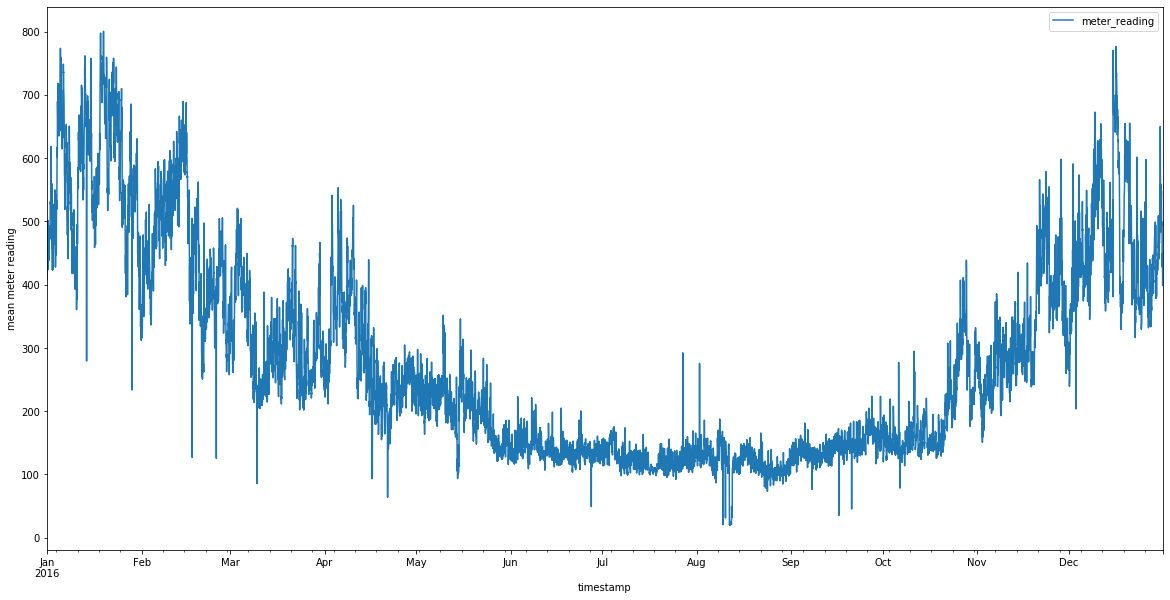

In [155]:
#plot the mean consumption of energy per month for the whole year to find patterns in data.
summaryTimestampOnly = train.groupby(["timestamp"]).agg("mean").reset_index()
summaryTimestampOnly.plot(x = "timestamp", y="meter_reading", figsize=(20,10))
plt.ylabel("mean meter reading")

### Generate the descriptive stats for each building

In [156]:
descriptiveStats = copy.deepcopy(train)
descriptiveStats.set_index(["building_id"], inplace=True)
descriptiveStats = descriptiveStats.groupby(descriptiveStats.index)["meter_reading"].agg(["min","max","mean","var"]).reset_index()
descriptiveStats.head(5)

,building_id,min,max,mean,var
0,106,0.0,40.0,5.069083,48.951132
1,109,0.0,200.0,26.867031,2013.972357
2,112,0.0,1791.1,63.926066,8112.414213
3,113,0.0,310.0,38.923241,376.441692
4,114,0.0,5700.0,170.981332,26147.454243


In [157]:
#Adding a column for hour in the main dataframe to facilitate further analysis.
train["hour"] = train.index.hour
train.reset_index(inplace=True)
train.head(2)

,timestamp,building_id,meter,meter_reading,primary_use,hour
0,2016-01-01,106,3,0.0,Education,0
1,2016-01-01,109,3,0.0,Education,0


## Clustering over aggregate (mean) meter reading of each building for whole year for hour from 1 to 24

### Generate the pivot table using mean as the statistic

In [158]:
perHourElectricityConsumptionEachBuilding = train.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
perHourElectricityConsumptionEachBuilding.reset_index(inplace=True)
perHourElectricityConsumptionEachBuilding.head(5)

hour,building_id,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,106,2.069456,1.928590,2.131068,2.049469,2.036358,4.057895,8.872017,6.662065,6.995842,...,6.418245,6.131648,6.385850,5.922649,5.898354,4.882657,4.795161,4.482326,2.177316,2.120847
1,109,19.164633,20.133874,16.842540,18.564877,19.768955,21.765181,18.275957,19.109166,28.241909,...,30.812459,37.619050,32.200602,33.388592,27.394800,23.046825,27.862020,19.295722,15.465875,15.675914
2,112,32.080142,32.831585,33.966693,31.583797,34.008875,48.268892,95.118373,74.198619,82.465808,...,79.126751,74.889609,79.487329,74.828009,67.230863,58.832724,56.645927,52.340733,34.150883,32.890996
3,113,36.773198,36.776476,36.565823,36.520315,36.106823,36.386694,37.262358,36.988225,36.422990,...,42.538296,42.996462,42.684437,42.291182,41.179797,39.427934,38.217474,37.947615,37.220456,37.219294
4,114,152.510136,153.877389,156.529895,160.106603,159.506651,162.771132,166.728684,207.026993,198.040936,...,171.379531,175.783287,167.374954,173.456363,163.794601,164.235057,165.462973,154.915840,150.182442,151.221062


### Generate the wcss vs cluster count and silhouette score vs cluster count plot

In [159]:
#setup for generating plot according to silhouette score for each number of clusters to extrcat the optimal number of clusters.
silhouette_scores = list()
inertia_list = list()
no_cluster = np.arange(2,30).astype(int) 

In [160]:
#scale the data for faster processing.
X = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuilding.values.copy())

In [161]:
#perform clustering with the required counts of clusters
for cluster in no_cluster:
    kmeans = KMeans(n_clusters=cluster, init="k-means++", n_init=10, n_jobs=-1,)
    c_f = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    inertia_list.append(kmeans.inertia_)

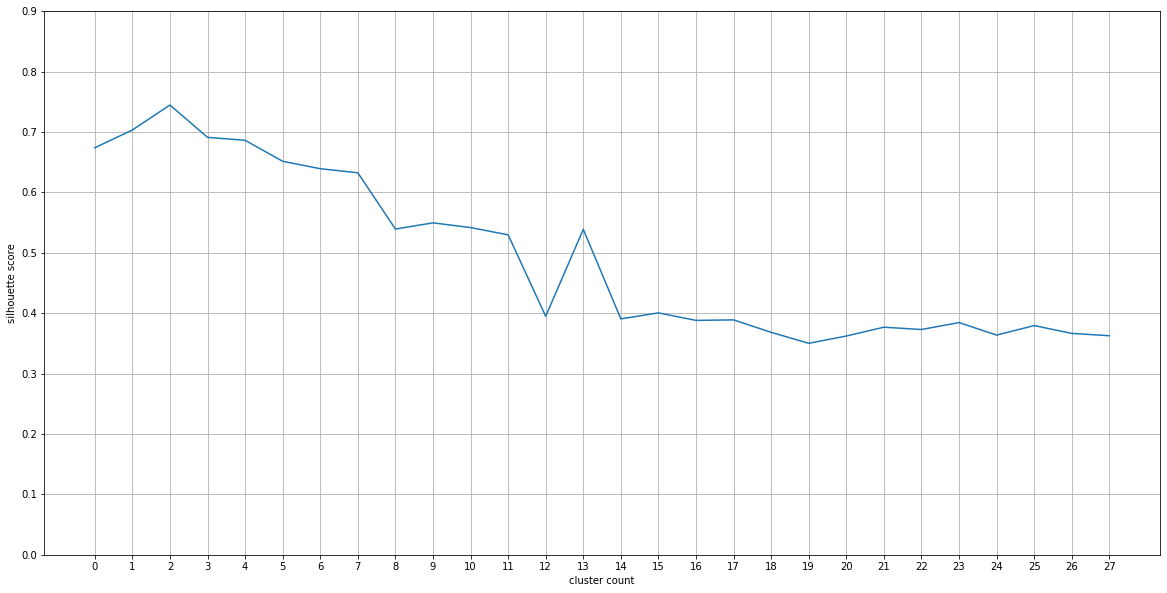

In [162]:
#plot the sihouette score vs cluster count graph.
plt.figure(figsize=(20,10))
plt.plot([i for i in range(0,28,1)], silhouette_scores)
plt.xticks([i for i in range(0,28,1)])
plt.yticks(np.arange(0,1,0.1))
plt.xlabel("cluster count")
plt.ylabel("silhouette score")
plt.grid()

### As silhouette score vs cluster count plot is not giving the desired result, we use elbow method to determine the best number of clusters

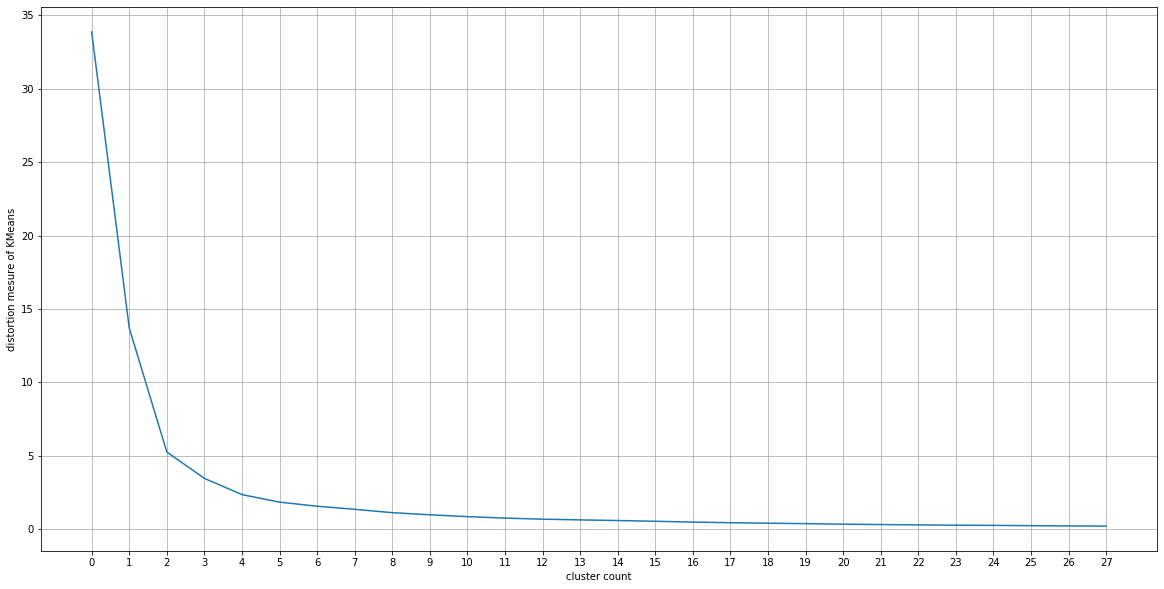

In [163]:
# plot the wcss vs cluster count graph
plt.figure(figsize=(20,10))
plt.plot([i for i in range(0,28,1)], inertia_list)
plt.xticks([i for i in range(0,28,1)])
plt.xlabel("cluster count")
plt.ylabel("distortion mesure of KMeans")
plt.grid()

### check the output of internal validation measure for cluster count = 2

In [164]:
kmeans = KMeans(n_clusters=2)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name="cluster")
perHourElectricityConsumptionEachBuilding.set_index("building_id", inplace=True)
perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr, append=True, inplace=True)
print("silhouette sample on euclidean metric: ",silhouette_samples(X, cluster_found))
print("silhouette score on euclidean metric: ",silhouette_score(X, cluster_found))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(X, cluster_found))
print("davis-B score on euclidean metric: ",davies_bouldin_score(X, cluster_found))

silhouette sample on euclidean metric:  [0.90488913 0.90958591 0.90520038 0.91213901 0.85655807 0.91440173
 0.85034428 0.64183835 0.92463891 0.92520103 0.92406003 0.90457598
 0.93116118 0.91911751 0.93397416 0.91867981 0.83599686 0.93584695
 0.93715355 0.93487546 0.93672905 0.93880714 0.93749356 0.93918948
 0.93784461 0.94169983 0.94036782 0.9414325  0.93833153 0.94020898
 0.94193606 0.94093336 0.93280035 0.93991191 0.84389707 0.94130669
 0.7559332  0.91647684 0.93918016 0.94055458 0.9379972  0.93922591
 0.92955329 0.93514737 0.92928095 0.93750193 0.93447838 0.88159405
 0.93603351 0.93498181 0.9333876  0.93252347 0.92834288 0.90045409
 0.92663483 0.93002388 0.8989411  0.92903849 0.92615986 0.92330799
 0.92312097 0.92293727 0.91766124 0.91786651 0.9069109  0.90607955
 0.90086093 0.05475491 0.14480499 0.2124103  0.39374979 0.34504413
 0.21036361 0.22252401 0.22900052 0.31362291 0.24380908 0.39516906
 0.27411095 0.30405246 0.32454539 0.36989955 0.32388124 0.33848478
 0.56856481 0.57391611

### visualizing the clusters obtained by reducing the data to 2 dimensions using ISOMAP, t-SNE, UMAP

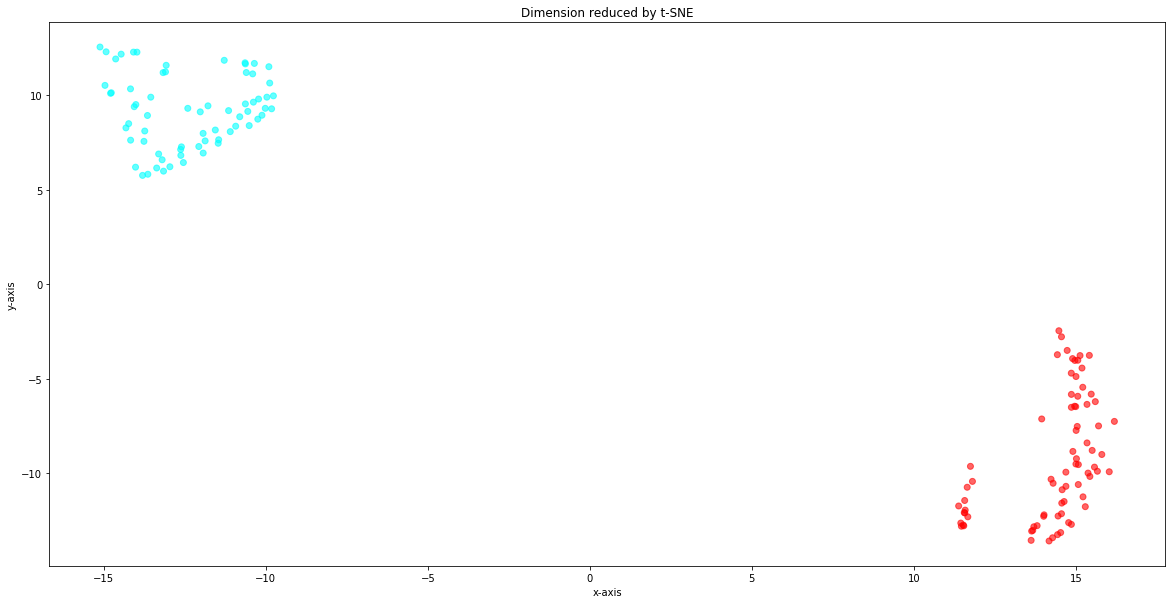

In [165]:
plot_tsne(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7)

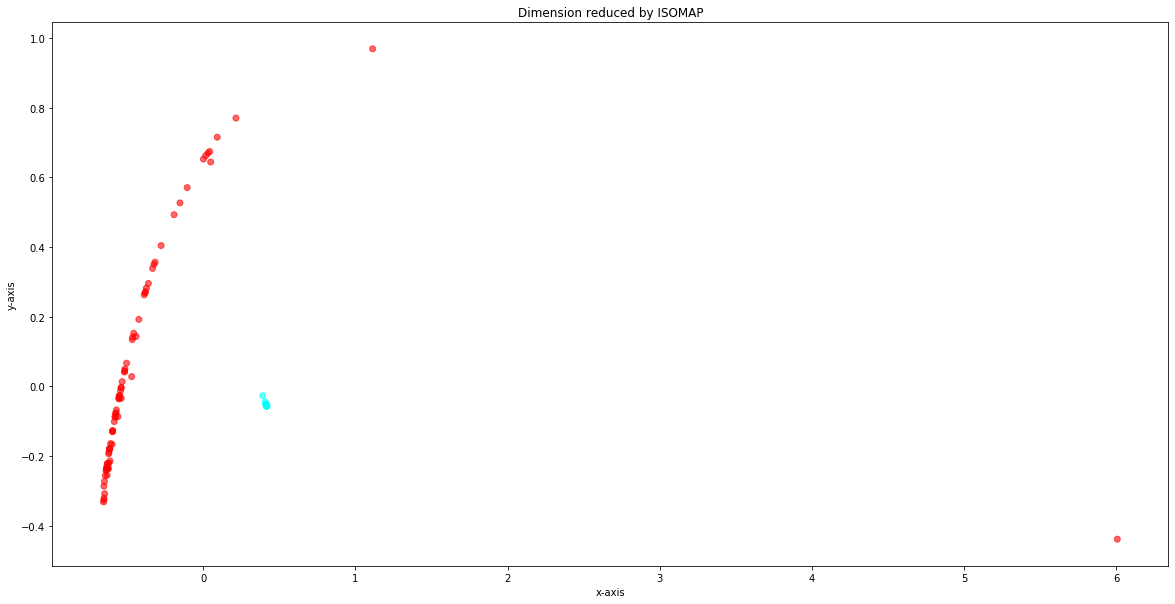

In [166]:
plot_isomap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


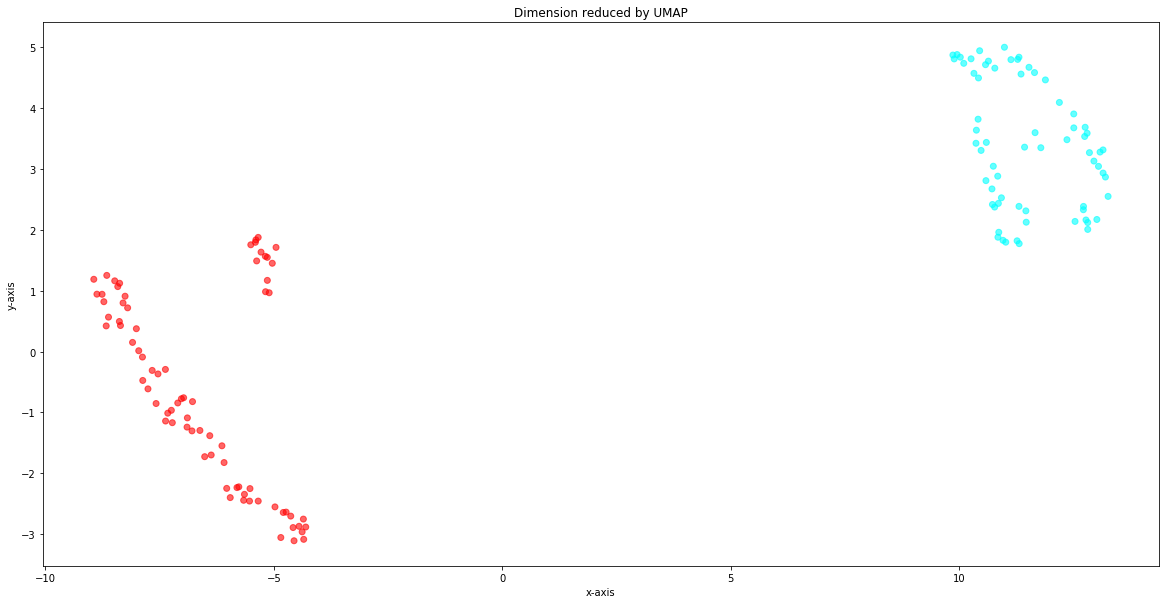

In [167]:
plot_umap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

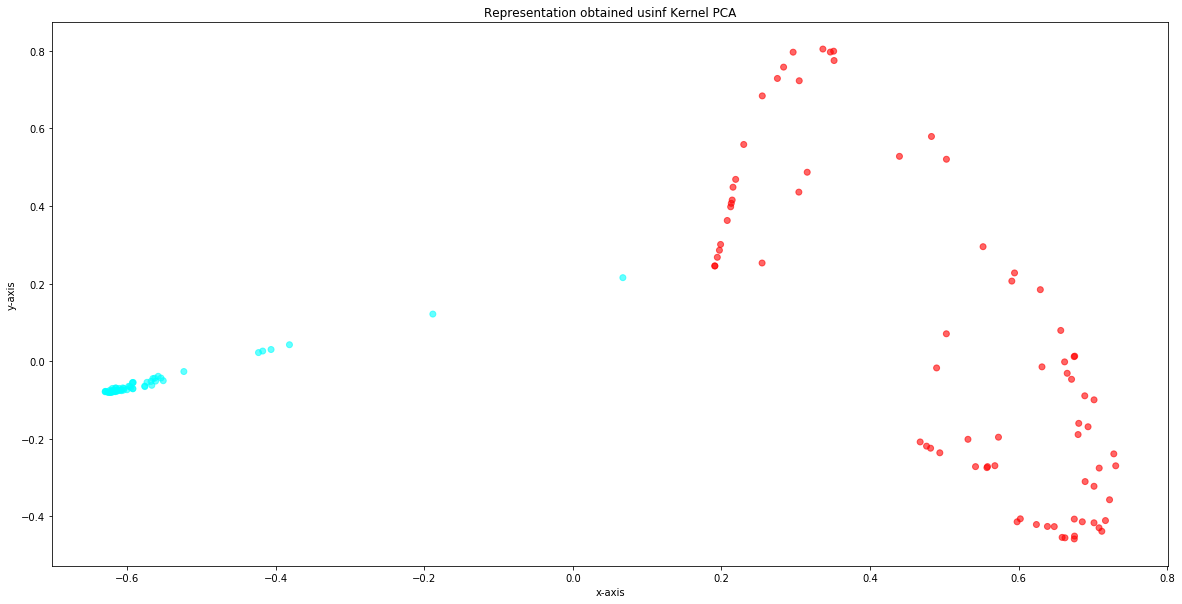

In [168]:
plot_kernel_pca(X, pivot=perHourElectricityConsumptionEachBuilding, kernel="rbf", g=15,rzev=True, deg = 1)

### As we see isomap gives the best representation of 2D for our data. In the subsequent sections we still will plot the points obtained via all 3 dimensionality reduction techniques but ISOMAP will be our emphasis.

### check the output of internal validation measure for cluster count = 3

In [169]:
perHourElectricityConsumptionEachBuilding.index = perHourElectricityConsumptionEachBuilding.index.droplevel(-1)
kmeans = KMeans(n_clusters=3)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name="cluster")
perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr, append=True, inplace=True)
print("silhouette sample on euclidean metric: ",silhouette_samples(X, cluster_found))
print("silhouette score on euclidean metric: ",silhouette_score(X, cluster_found))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(X, cluster_found))
print("davis-B score on euclidean metric: ",davies_bouldin_score(X, cluster_found))

silhouette sample on euclidean metric:  [0.90007811 0.90498735 0.90034905 0.90764986 0.84917977 0.91001373
 0.84261768 0.6240547  0.92070802 0.9212935  0.92009077 0.89953264
 0.92750435 0.91476583 0.93045236 0.91429625 0.82712334 0.93241188
 0.93377633 0.93137682 0.93332481 0.93550574 0.93411323 0.93589538
 0.93447161 0.93851981 0.93711698 0.93822462 0.93496131 0.93692381
 0.93873091 0.9376657  0.92906705 0.9365933  0.83512216 0.93804973
 0.74227626 0.91177888 0.93579331 0.93723597 0.93453967 0.93582439
 0.92557497 0.93148181 0.92526986 0.93398529 0.93078967 0.87482763
 0.93240496 0.93128834 0.92957578 0.92867873 0.92425025 0.89467093
 0.92239461 0.92598871 0.89305159 0.9249531  0.92190238 0.91884617
 0.91868552 0.9184381  0.91287764 0.9130881  0.90142197 0.90050103
 0.89497173 0.14700647 0.15047951 0.24486788 0.46085539 0.42875319
 0.30016016 0.31181844 0.31819356 0.40065633 0.33268195 0.47536212
 0.2970881  0.39097143 0.41106576 0.45429608 0.41024193 0.42445254
 0.63580394 0.63832605

### visualizing the clusters obtained by reducing the data to 2 dimensions using ISOMAP, t-SNE, UMAP

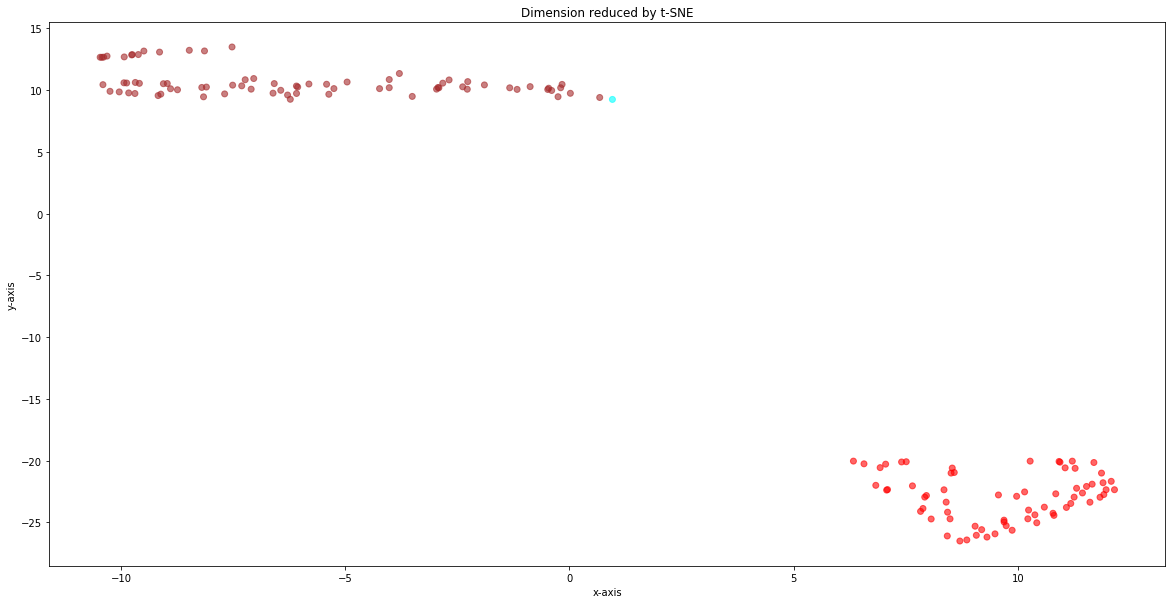

In [170]:
plot_tsne(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7)

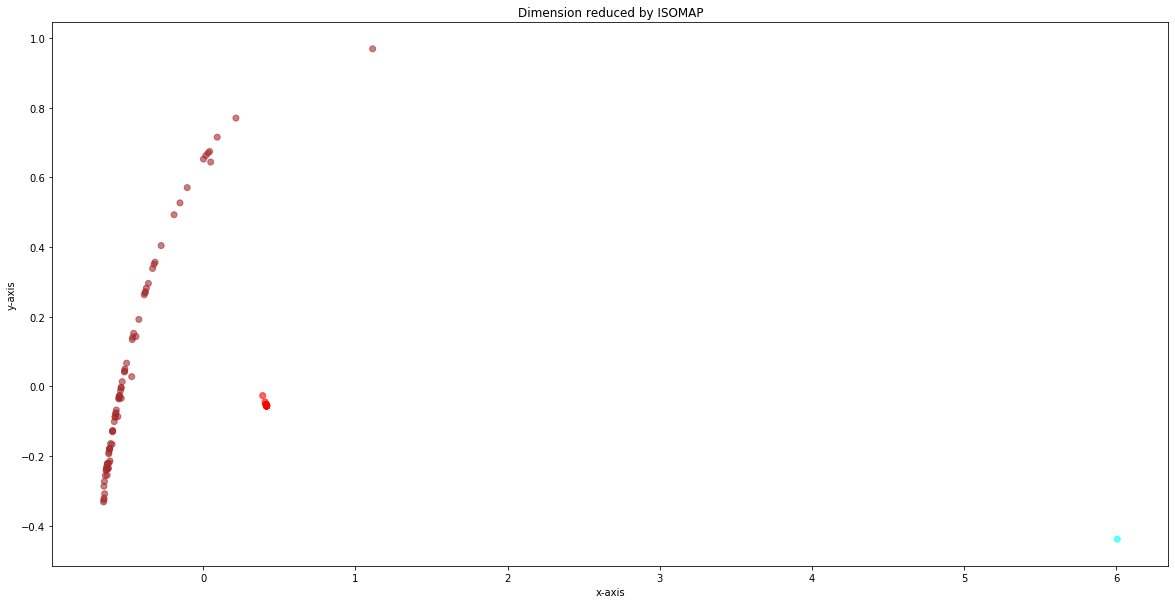

In [171]:
plot_isomap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


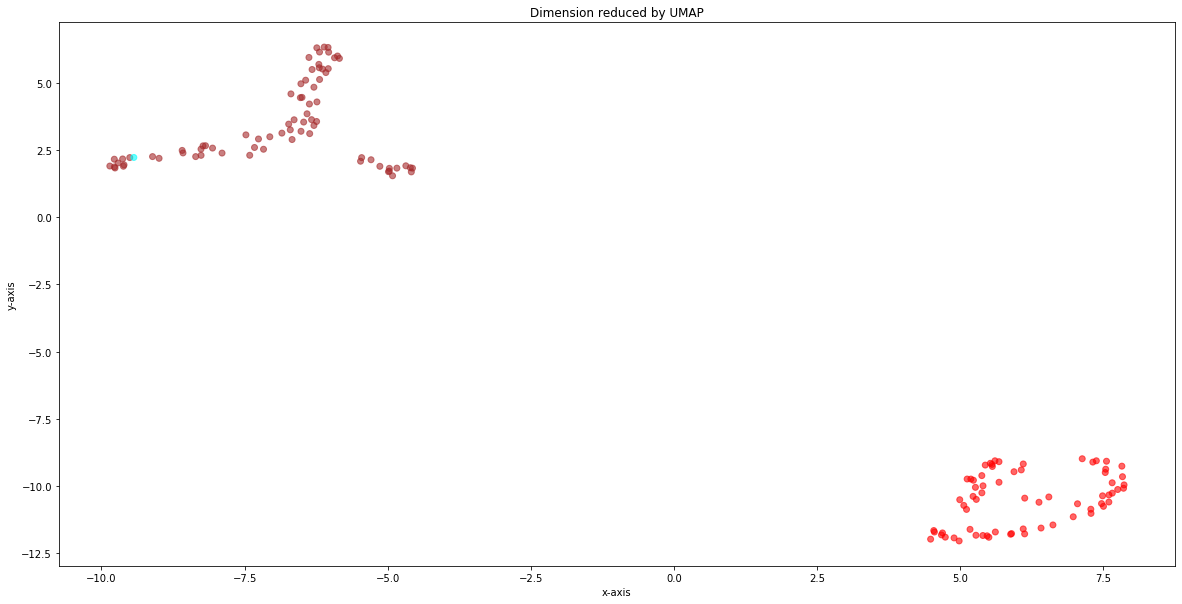

In [172]:
plot_umap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

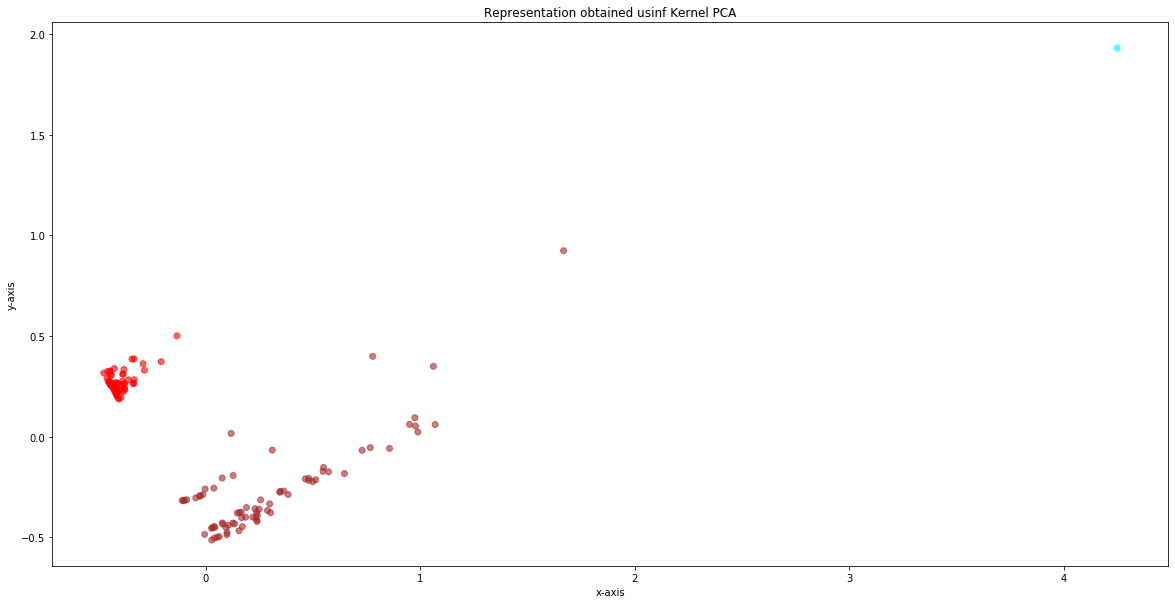

In [173]:
plot_kernel_pca(X, pivot=perHourElectricityConsumptionEachBuilding, kernel="linear", g=30,rzev=True, deg = 1)

### check the output of internal validation measure for cluster count = 4

In [174]:
perHourElectricityConsumptionEachBuilding.index = perHourElectricityConsumptionEachBuilding.index.droplevel(-1)
kmeans = KMeans(n_clusters=4)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name="cluster")
perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr, append=True, inplace=True)
print("silhouette sample on euclidean metric: ",silhouette_samples(X, cluster_found))
print("silhouette score on euclidean metric: ",silhouette_score(X, cluster_found))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(X, cluster_found))
print("davis-B score on euclidean metric: ",davies_bouldin_score(X, cluster_found))

silhouette sample on euclidean metric:  [0.89112741 0.89657644 0.89174959 0.89950039 0.83745689 0.90202279
 0.83045524 0.60610881 0.91340555 0.91406839 0.91255305 0.89077132
 0.92047134 0.90697307 0.92368496 0.9064558  0.81322395 0.92580607
 0.92726881 0.9245925  0.92674064 0.92914467 0.927546   0.92951578
 0.92790095 0.93239086 0.93080091 0.93211184 0.92836401 0.93049951
 0.9325842  0.93143396 0.92210336 0.93007972 0.82079513 0.93167342
 0.72285686 0.90320824 0.9291118  0.93073038 0.92769998 0.92911085
 0.91808075 0.92446006 0.91769833 0.9270149  0.92343064 0.86265624
 0.92520412 0.92394022 0.92214441 0.92099024 0.91600372 0.88402554
 0.91419197 0.91803834 0.88219613 0.91677628 0.91331993 0.91017059
 0.90969236 0.9095647  0.90311686 0.90334857 0.89011495 0.88908358
 0.88278028 0.27604645 0.39650277 0.47514543 0.48661176 0.59385101
 0.51077745 0.52133217 0.52719486 0.59185223 0.54034619 0.62487887
 0.59294633 0.59128345 0.60824667 0.6360347  0.60739196 0.61891155
 0.77375249 0.74801778

### visualizing the clusters obtained by reducing the data to 2 dimensions using ISOMAP, t-SNE, UMAP

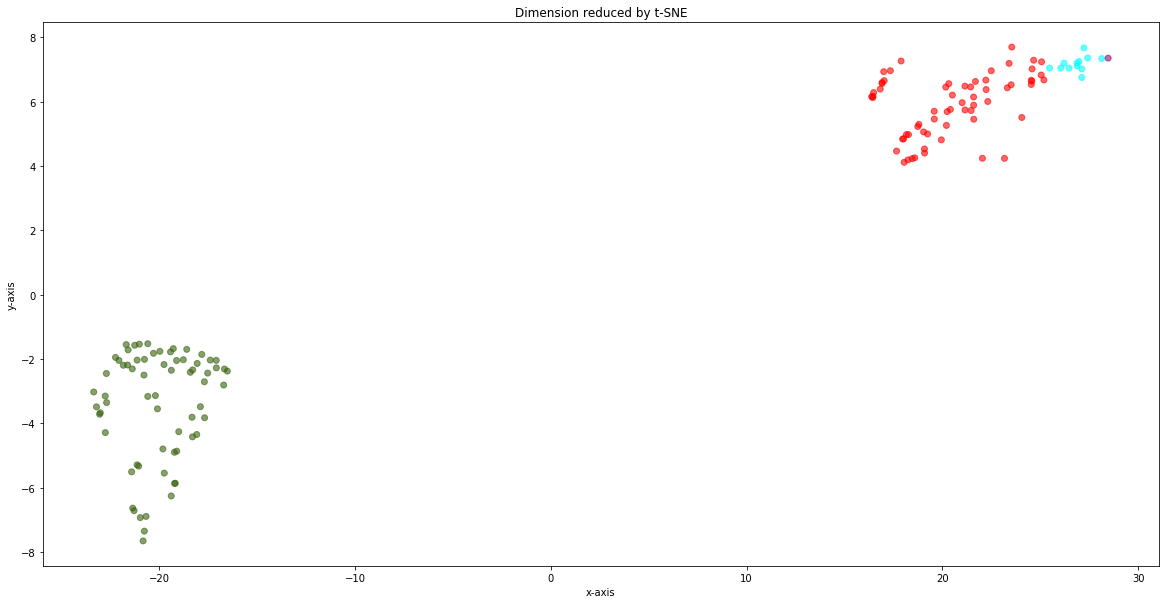

In [175]:
plot_tsne(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7)

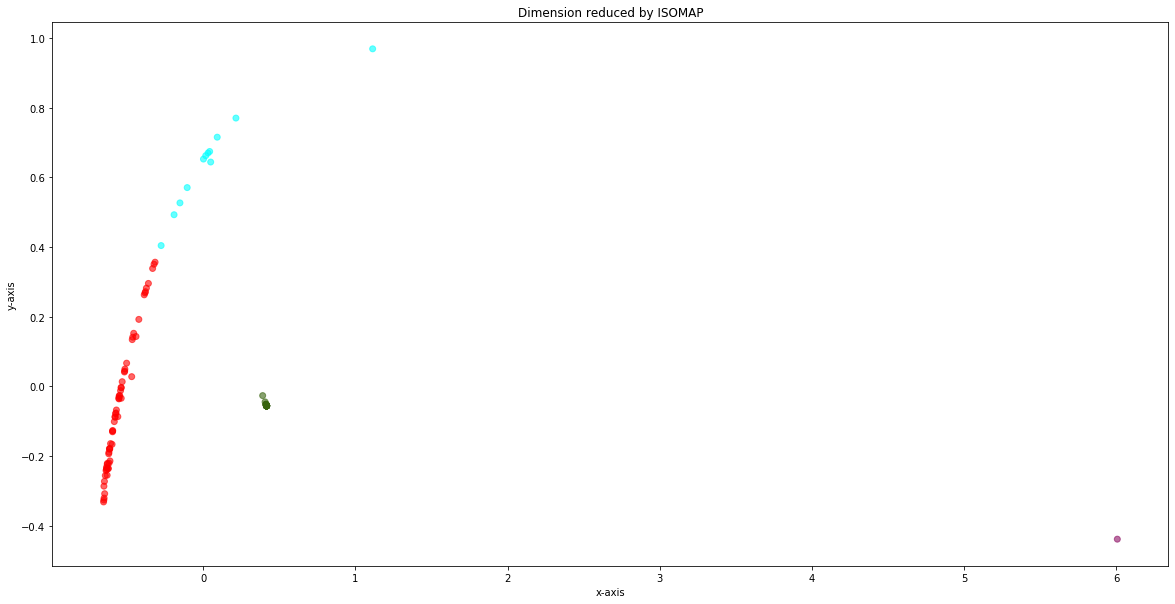

In [176]:
plot_isomap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


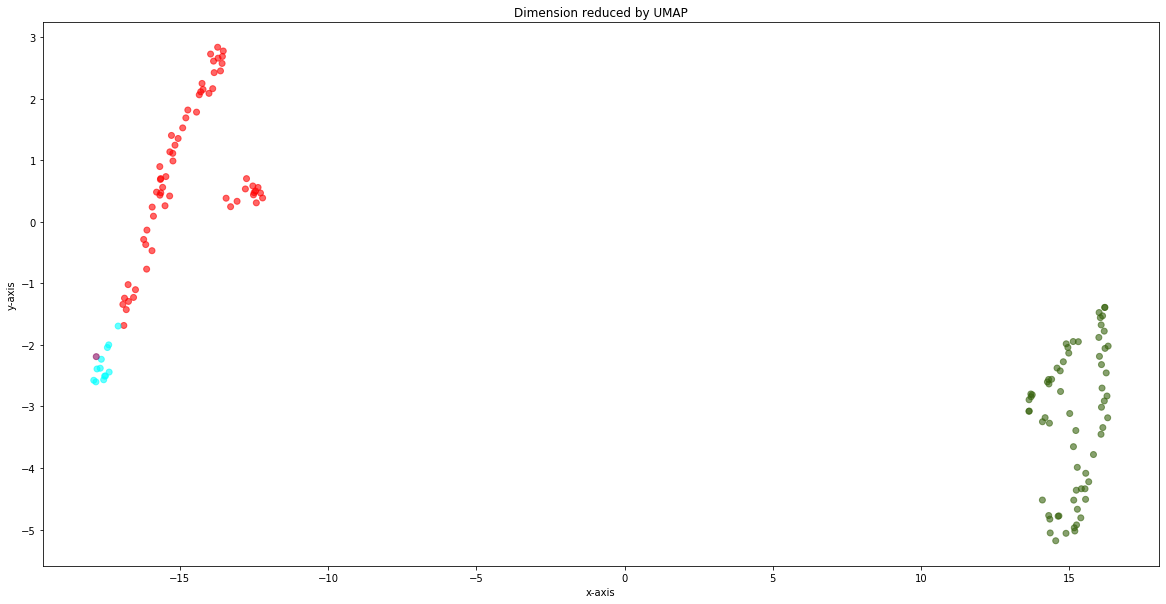

In [177]:
plot_umap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

### We see that even increasing the cluster count does not improve the internal validation score of our clusters. Hence, we shall be dividing the data into quarters and experimenting with the same technique once again. 

### Some other observations

### Associate each building with its primary use

In [178]:
#map corresponding building to its primary use
temp = train.drop_duplicates(["building_id","primary_use"])
temp = temp[["building_id", "primary_use"]]
temp.set_index("building_id")
temp.sort_values(by="building_id", inplace=True) 

### Get a count of total number of each category in primary use

In [179]:
#make a copy oforiginalpivot_table
temp2 = copy.deepcopy(perHourElectricityConsumptionEachBuilding)
perHourElectricityConsumptionEachBuilding.reset_index(level = ["building_id","cluster"], inplace=True)
perHourElectricityConsumptionEachBuilding = pd.merge(perHourElectricityConsumptionEachBuilding,temp, left_on="building_id", right_on="building_id", how="left")
perHourElectricityConsumptionEachBuilding.set_index(["building_id","cluster"], inplace=True)
perHourElectricityConsumptionEachBuilding.groupby([perHourElectricityConsumptionEachBuilding.index.get_level_values("cluster"),"primary_use"])["primary_use"].agg("count")
perHourElectricityConsumptionEachBuilding

,,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,primary_use
building_id,cluster,,,,,,,,,,,,,,,,,,,,,
106,1,2.069456,1.928590,2.131068,2.049469,2.036358,4.057895,8.872017,6.662065,6.995842,7.955608,...,6.131648,6.385850,5.922649,5.898354,4.882657,4.795161,4.482326,2.177316,2.120847,Education
109,1,19.164633,20.133874,16.842540,18.564877,19.768955,21.765181,18.275957,19.109166,28.241909,37.457627,...,37.619050,32.200602,33.388592,27.394800,23.046825,27.862020,19.295722,15.465875,15.675914,Education
112,1,32.080142,32.831585,33.966693,31.583797,34.008875,48.268892,95.118373,74.198619,82.465808,103.215160,...,74.889609,79.487329,74.828009,67.230863,58.832724,56.645927,52.340733,34.150883,32.890996,Education
113,1,36.773198,36.776476,36.565823,36.520315,36.106823,36.386694,37.262358,36.988225,36.422990,36.650871,...,42.996462,42.684437,42.291182,41.179797,39.427934,38.217474,37.947615,37.220456,37.219294,Education
114,1,152.510136,153.877389,156.529895,160.106603,159.506651,162.771132,166.728684,207.026993,198.040936,200.939166,...,175.783287,167.374954,173.456363,163.794601,164.235057,165.462973,154.915840,150.182442,151.221062,Education
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,3,1099.331087,1067.836393,1076.677942,1024.406898,1108.383562,1109.646424,1140.934746,1133.199817,1140.500870,1137.678290,...,1126.678694,1118.045323,1062.114184,1003.707175,929.226311,936.539168,909.962378,970.399336,949.878879,Entertainment/public assembly
1323,3,1332.740992,1381.277391,1400.063213,1295.464410,1206.231328,1237.028233,1239.914340,1252.168099,1273.519809,1286.289828,...,1437.191090,1354.412227,1306.725260,1278.659158,1258.896989,1240.363492,1248.343574,1280.095391,1295.780989,Office
1324,0,133.593709,133.155315,150.545918,153.597102,193.346659,183.639847,191.462495,222.234930,210.601111,208.243920,...,209.055799,142.656599,132.239082,116.193982,105.140485,100.478740,104.150399,101.951141,110.686648,Entertainment/public assembly


### assign a numeric value to each categpry in primary use for further use in later sections

In [180]:
perHourElectricityConsumptionEachBuilding["code"] = perHourElectricityConsumptionEachBuilding["primary_use"].astype("category").cat.codes
perHourElectricityConsumptionEachBuilding

,,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,primary_use,code
building_id,cluster,,,,,,,,,,,,,,,,,,,,,
106,1,2.069456,1.928590,2.131068,2.049469,2.036358,4.057895,8.872017,6.662065,6.995842,7.955608,...,6.385850,5.922649,5.898354,4.882657,4.795161,4.482326,2.177316,2.120847,Education,0
109,1,19.164633,20.133874,16.842540,18.564877,19.768955,21.765181,18.275957,19.109166,28.241909,37.457627,...,32.200602,33.388592,27.394800,23.046825,27.862020,19.295722,15.465875,15.675914,Education,0
112,1,32.080142,32.831585,33.966693,31.583797,34.008875,48.268892,95.118373,74.198619,82.465808,103.215160,...,79.487329,74.828009,67.230863,58.832724,56.645927,52.340733,34.150883,32.890996,Education,0
113,1,36.773198,36.776476,36.565823,36.520315,36.106823,36.386694,37.262358,36.988225,36.422990,36.650871,...,42.684437,42.291182,41.179797,39.427934,38.217474,37.947615,37.220456,37.219294,Education,0
114,1,152.510136,153.877389,156.529895,160.106603,159.506651,162.771132,166.728684,207.026993,198.040936,200.939166,...,167.374954,173.456363,163.794601,164.235057,165.462973,154.915840,150.182442,151.221062,Education,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,3,1099.331087,1067.836393,1076.677942,1024.406898,1108.383562,1109.646424,1140.934746,1133.199817,1140.500870,1137.678290,...,1118.045323,1062.114184,1003.707175,929.226311,936.539168,909.962378,970.399336,949.878879,Entertainment/public assembly,1
1323,3,1332.740992,1381.277391,1400.063213,1295.464410,1206.231328,1237.028233,1239.914340,1252.168099,1273.519809,1286.289828,...,1354.412227,1306.725260,1278.659158,1258.896989,1240.363492,1248.343574,1280.095391,1295.780989,Office,5
1324,0,133.593709,133.155315,150.545918,153.597102,193.346659,183.639847,191.462495,222.234930,210.601111,208.243920,...,142.656599,132.239082,116.193982,105.140485,100.478740,104.150399,101.951141,110.686648,Entertainment/public assembly,1


# Divide data into quarters and perform the above experiment.

#### Experiment over quarter 1

In [181]:
quarter1 = copy.deepcopy(train)
quarter1["quarter"] = quarter1["timestamp"].dt.quarter
quarter1 = quarter1[quarter1["quarter"]==1]
quarter1["meter_reading"].fillna(0, inplace=True)

In [182]:
perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
#perHourElectricityConsumptionEachBuildingQ1.drop(perHourElectricityConsumptionEachBuildingQ1.index[[1100,779,1198,1089,1022,1169,1160,1149,1285]], inplace=True)
perHourElectricityConsumptionEachBuildingQ1.head(5)

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
building_id,,,,,,,,,,,,,,,,,,,,,
106,4.574112,3.693738,4.244162,3.821100,4.159203,5.041580,18.893641,13.444534,13.394921,18.218901,...,14.487569,13.469134,14.749933,13.157805,12.974757,10.069767,10.361977,10.193632,4.558893,4.037519
109,23.199632,25.385386,22.340676,24.588981,35.505268,29.437126,21.532513,30.532830,42.623254,51.712142,...,49.878097,58.422860,50.064487,61.637237,37.798712,24.880464,50.417984,28.837652,14.493952,29.114875
112,77.095913,64.967577,69.329204,63.390742,73.267148,71.705822,202.328404,142.727786,166.438427,252.644968,...,189.516166,174.464945,194.918327,173.888236,153.628163,121.929789,128.892123,111.624692,74.643271,67.592387
113,59.320762,58.438229,59.061816,58.533047,58.316711,57.984936,58.930574,58.434686,56.205162,55.059884,...,67.319060,67.418345,67.330351,67.522151,67.125926,62.674633,61.831684,60.824305,60.809129,60.261522
114,281.360385,283.189945,291.649220,290.148341,294.947648,302.256582,303.535220,401.144516,361.659923,371.223462,...,314.974033,316.003418,305.130703,316.179835,303.304725,300.571736,307.187385,287.860319,290.834901,281.330198


In [183]:
XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuildingQ1.values.copy())
XQ1

array([[3.86441011e-04, 3.07310022e-04, 3.55498074e-04, ...,
        8.69115837e-04, 3.81993446e-04, 3.42217555e-04],
       [1.96000645e-03, 2.11200211e-03, 1.87129240e-03, ...,
        2.45871737e-03, 1.21446019e-03, 2.46775855e-03],
       [6.51340023e-03, 5.40514378e-03, 5.80713019e-03, ...,
        9.51719556e-03, 6.25442140e-03, 5.72908836e-03],
       ...,
       [2.32259259e-02, 2.42526842e-02, 2.45930184e-02, ...,
        2.27678438e-02, 2.10991174e-02, 2.06571056e-02],
       [2.34090511e-02, 2.22867820e-02, 2.24195775e-02, ...,
        2.34047916e-02, 2.29019581e-02, 2.30011118e-02],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [184]:
silhouette_scores_q1 = list()
inertia = list()
no_cluster = np.arange(2,28).astype("int")
for cluster in no_cluster:
    kmeansQ1 = KMeans(n_clusters=cluster, init="k-means++")
    c_f = kmeansQ1.fit_predict(XQ1)
    silhouette_scores_q1.append(silhouette_score(XQ1, kmeansQ1.labels_))
    inertia.append(kmeansQ1.inertia_)
    

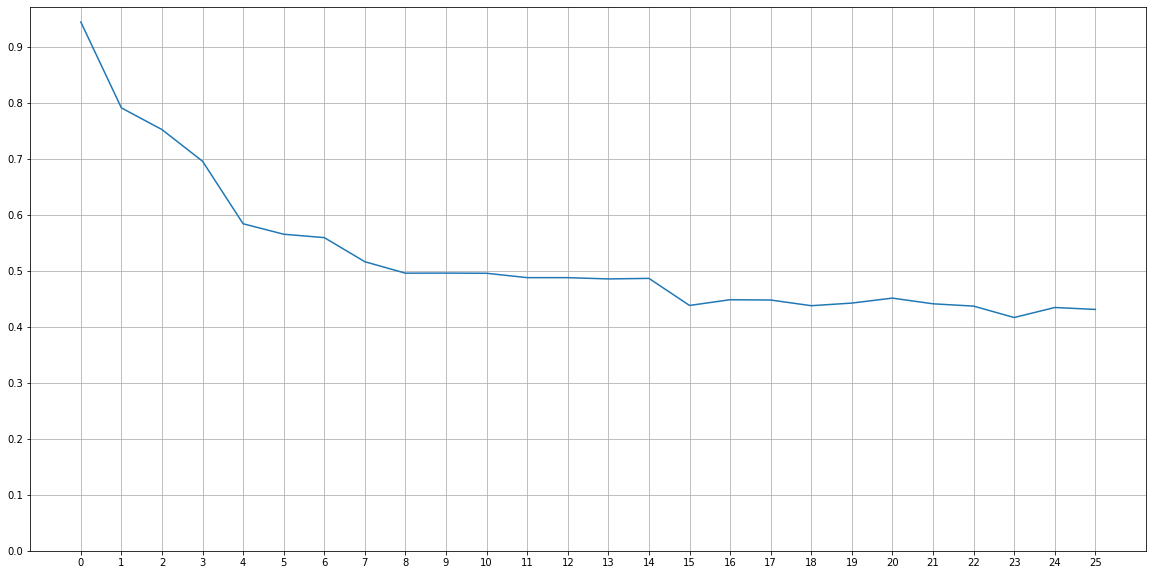

In [185]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(0,26,1)], silhouette_scores_q1)
plt.xticks([i for i in range(0,26,1)])
plt.yticks(np.arange(0,1,0.1))
plt.grid()

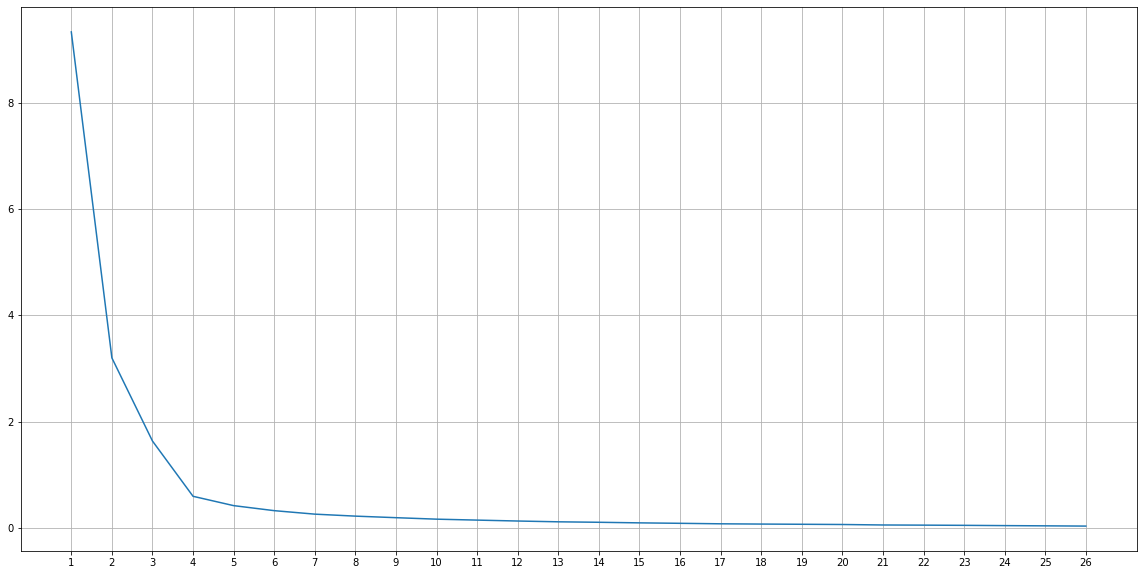

In [186]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(1,27,1)], inertia)
plt.xticks([i for i in range(1,27,1)])
plt.grid()

#### Clustering with euclidean distance

In [187]:
kmeans = KMeans(n_clusters=3)
cluster_found_q1 = kmeans.fit_predict(XQ1)
cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)

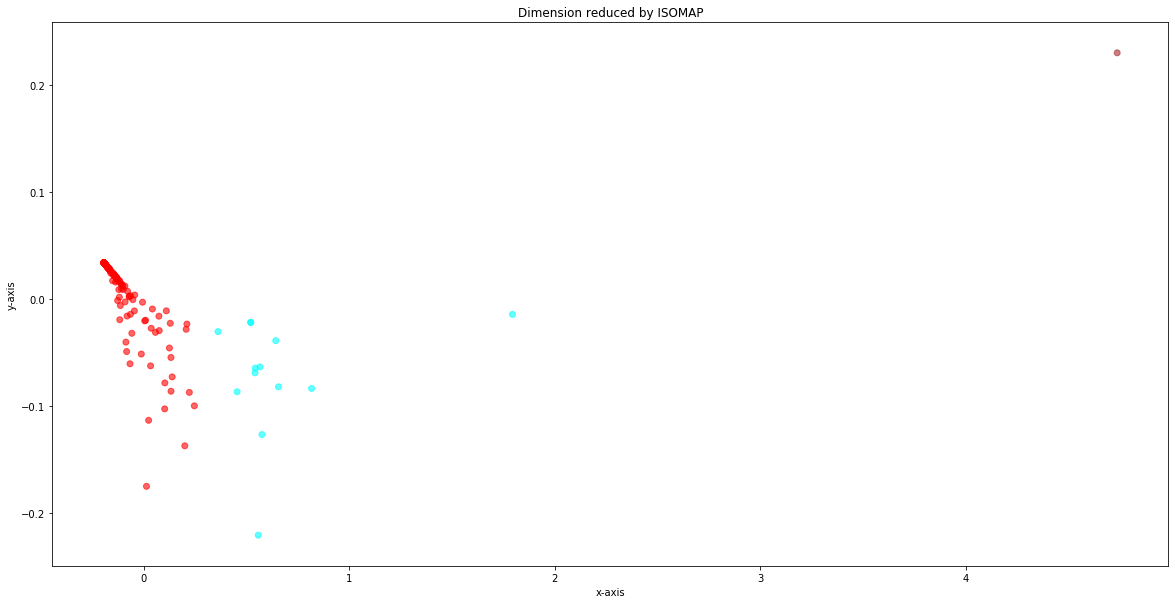

In [188]:
plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor=10)

#### Clustering with DTW distance

In [189]:
perHourElectricityConsumptionEachBuildingQ1.index = perHourElectricityConsumptionEachBuildingQ1.index.droplevel(-1)
kmeansTslearn = TimeSeriesKMeans(n_clusters=3, max_iter=1000, metric="dtw", n_jobs=4, init="k-means++")
cluster_found_q1 = kmeansTslearn.fit_predict(XQ1)
cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)

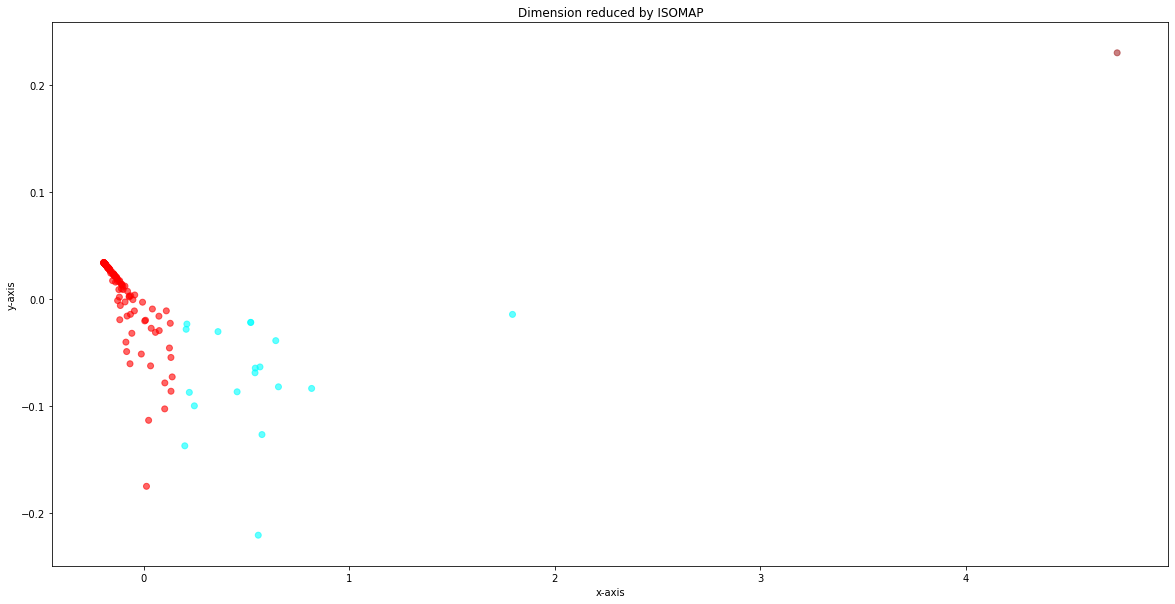

In [190]:
plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor = 10)

In [191]:
# printing the score of internal validation measures
print("silhouette score on euclidean metric: ",silhouette_score(XQ1, kmeans.labels_))
print("silhouette score on dtw metric: ",silhouette_score(XQ1, kmeansTslearn.labels_))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, kmeans.labels_))
print("calsinki-H score on dtw metric: ",calinski_harabasz_score(XQ1, kmeansTslearn.labels_))
print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, kmeans.labels_))
print("davis-B score on dtw metric: ",davies_bouldin_score(XQ1, kmeansTslearn.labels_))

silhouette score on euclidean metric:  0.7907108596629537
silhouette score on dtw metric:  0.7622647565965792
calsinki-H score on euclidean metric:  621.9681283534136
calsinki-H score on dtw metric:  598.4321292630625
davis-B score on euclidean metric:  0.3069529795310966
davis-B score on dtw metric:  0.3398458138725638


## Perform Kmeans on quarter 2 with distances: euclidean, DTW

Internal Validation scores for quarter 2
silhouette score on euclidean metric:  0.764652266771774
silhouette score on dtw metric:  0.7337808240546363
calsinki-H score on euclidean metric:  411.71806932525647
calsinki-H score on dtw metric:  178.33412625016473
davis-B score on euclidean metric:  0.3959864085048071
davis-B score on dtw metric:  0.6890816464863673


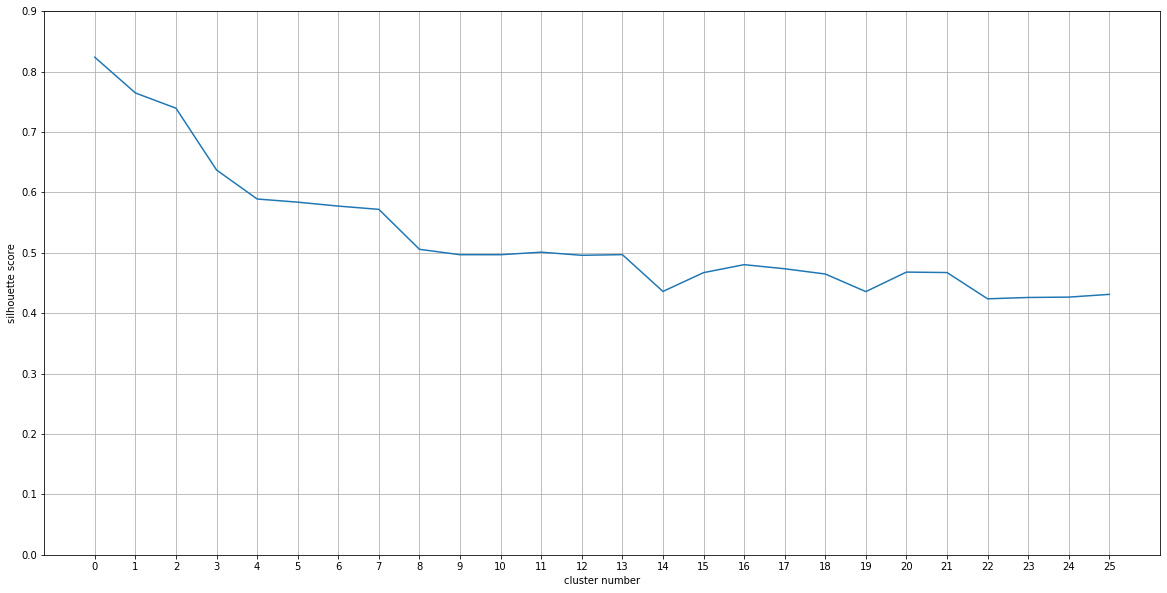

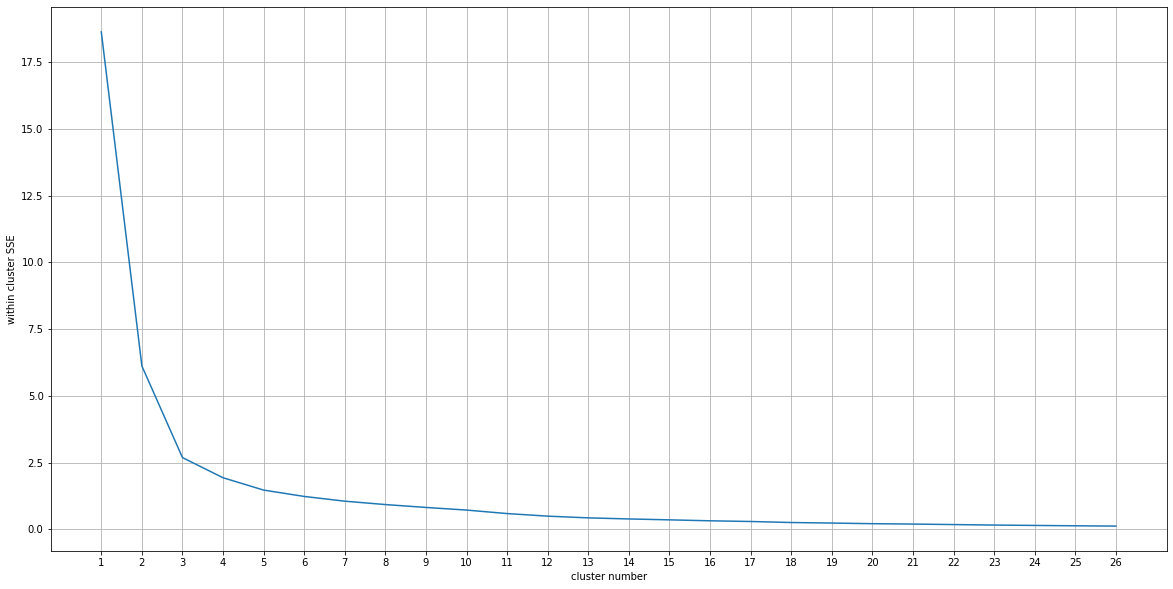

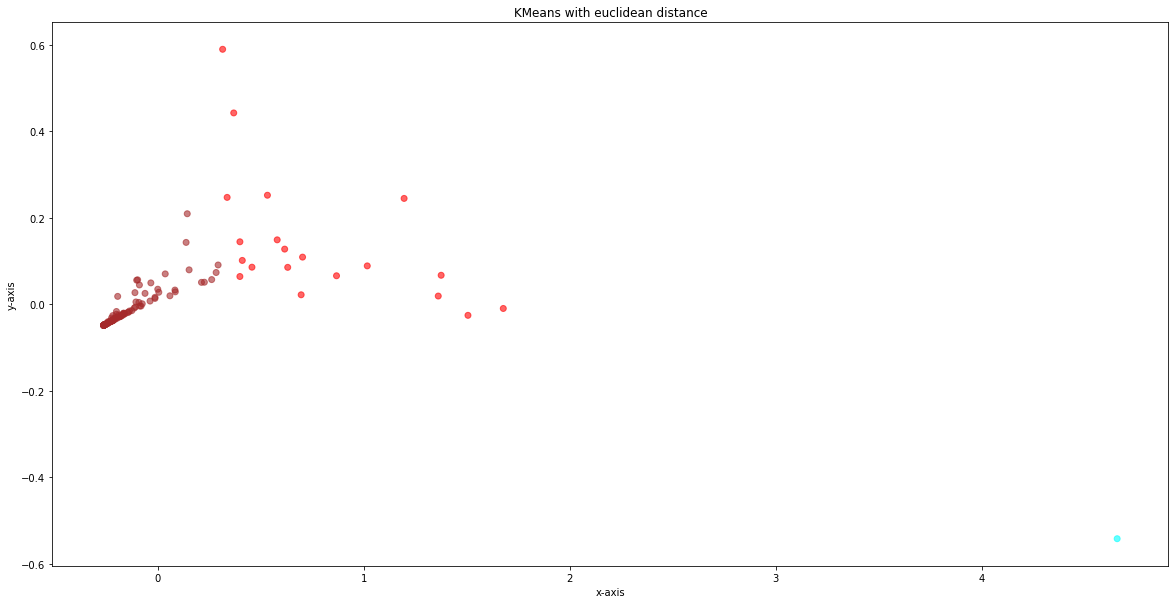

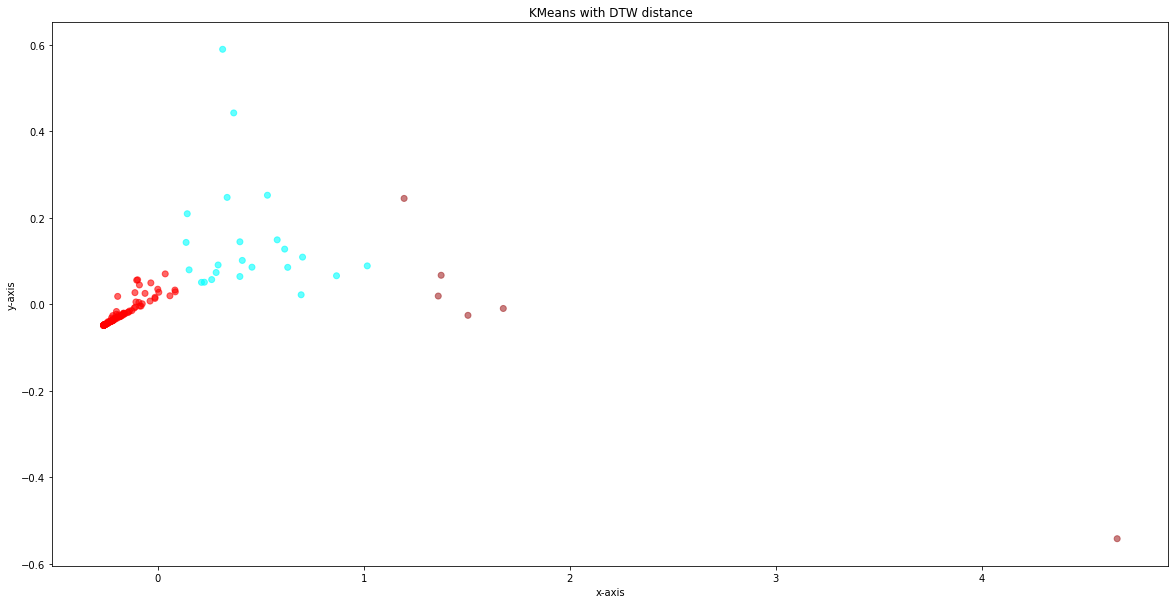

In [192]:
perform_clustering_quarter_wise(2, train)

## Perform Kmeans on quarter 3 with distances: euclidean, DTW

Internal Validation scores for quarter 3
silhouette score on euclidean metric:  0.7661716633897095
silhouette score on dtw metric:  0.7621520461687294
calsinki-H score on euclidean metric:  406.2486469403711
calsinki-H score on dtw metric:  402.05116597215954
davis-B score on euclidean metric:  0.6055098075678728
davis-B score on dtw metric:  0.6065618138265055


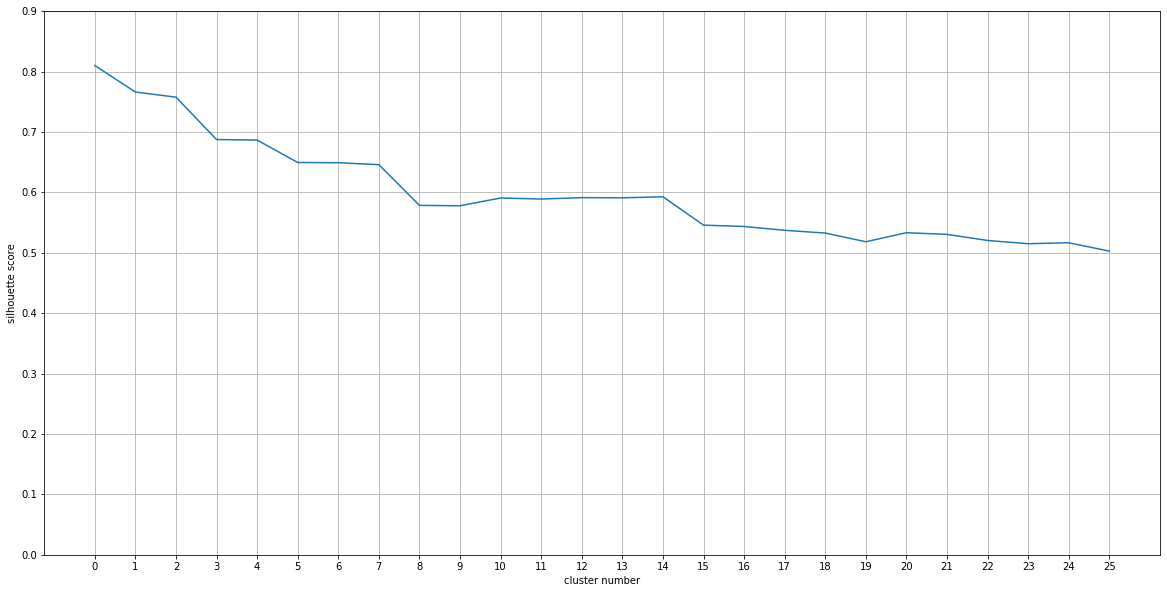

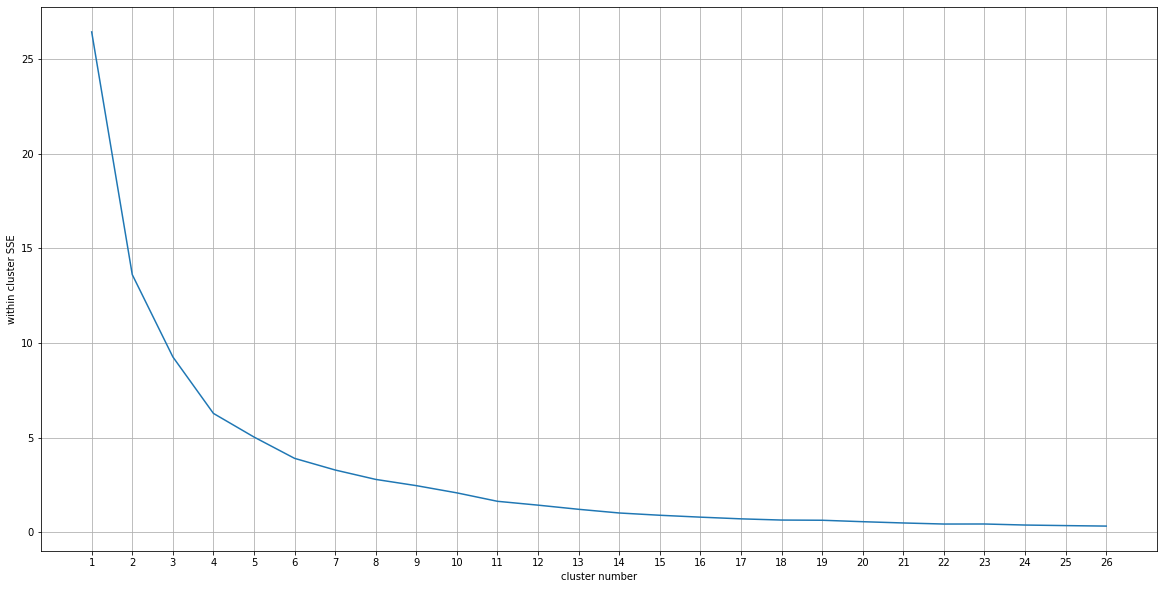

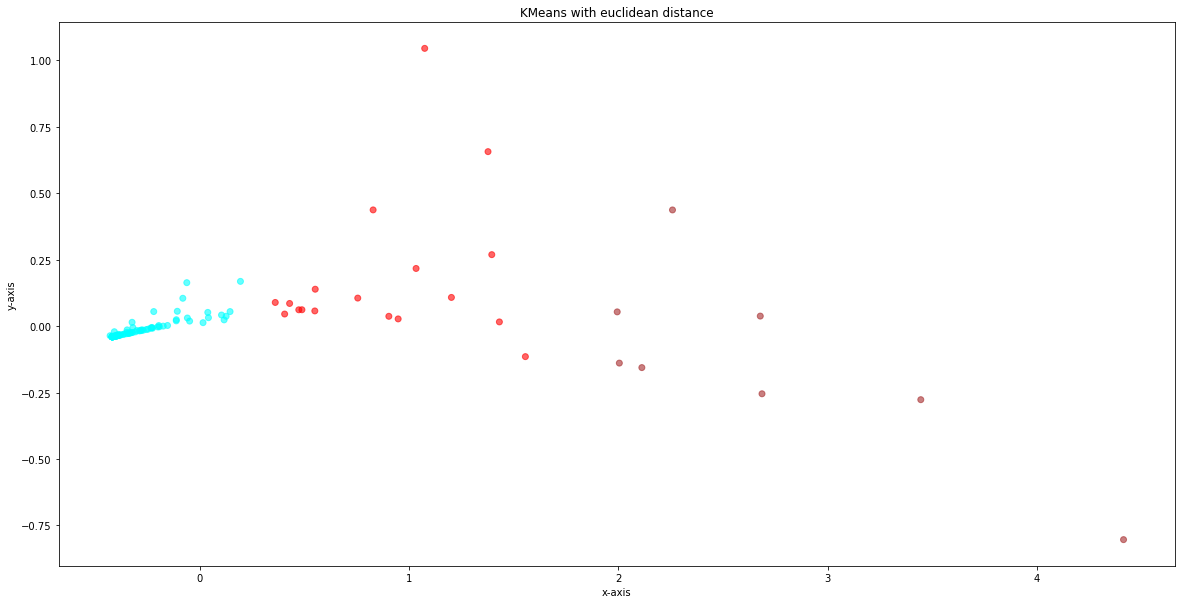

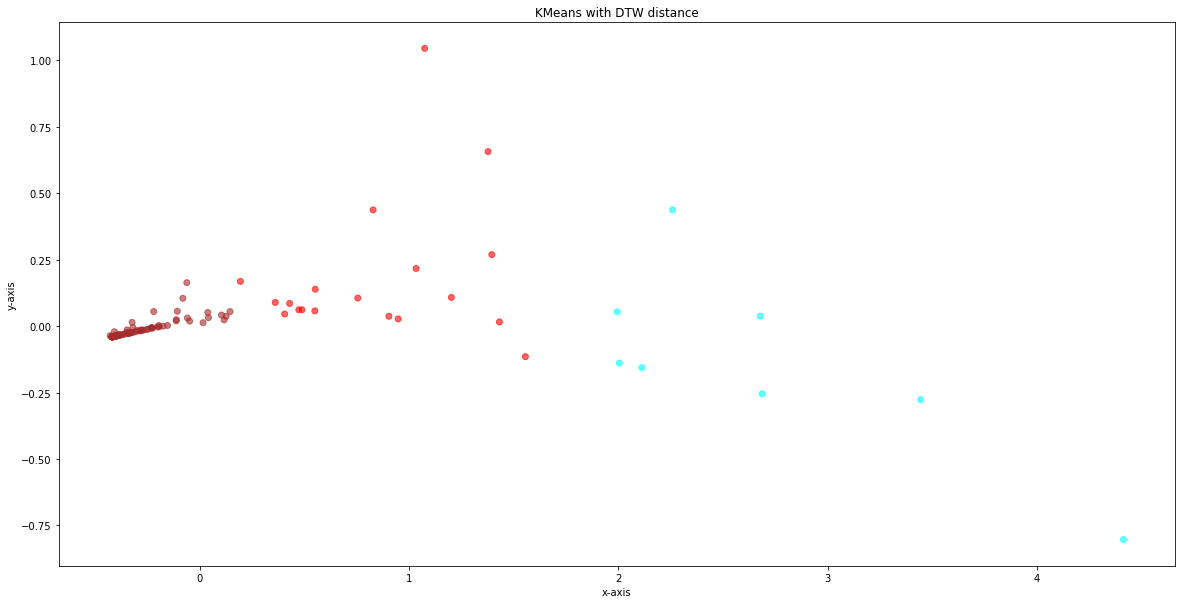

In [193]:
perform_clustering_quarter_wise(3, train)

## Perform Kmeans on quarter 4 with distances: euclidean, DTW

Internal Validation scores for quarter 4
silhouette score on euclidean metric:  0.7691389889826393
silhouette score on dtw metric:  0.7691389889826393
calsinki-H score on euclidean metric:  450.0161147096098
calsinki-H score on dtw metric:  450.0161147096098
davis-B score on euclidean metric:  0.36599603761705196
davis-B score on dtw metric:  0.36599603761705196


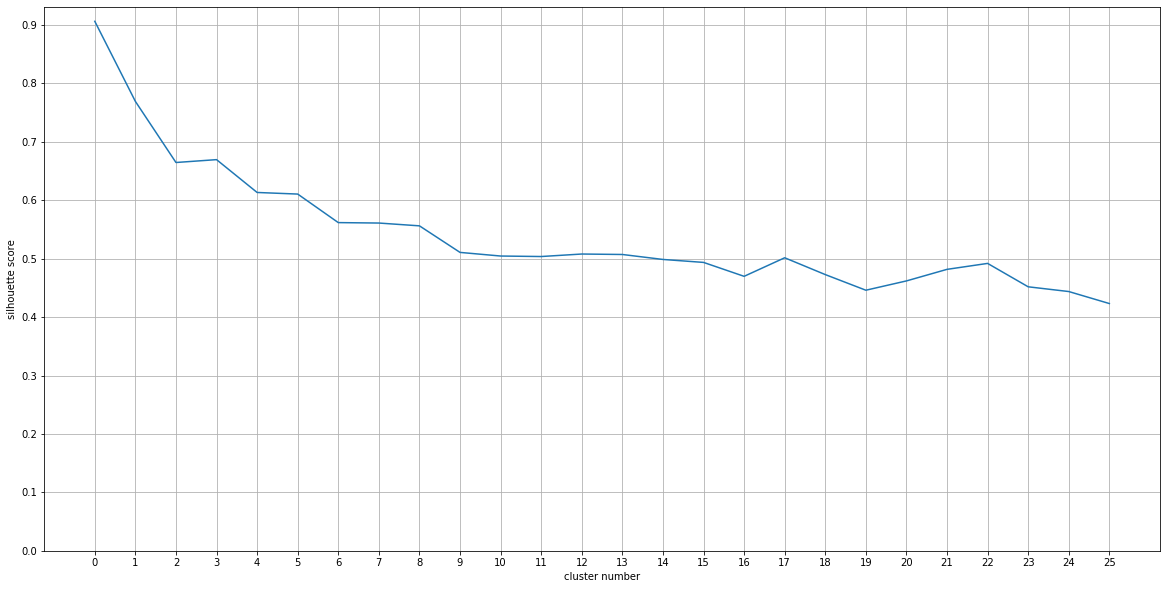

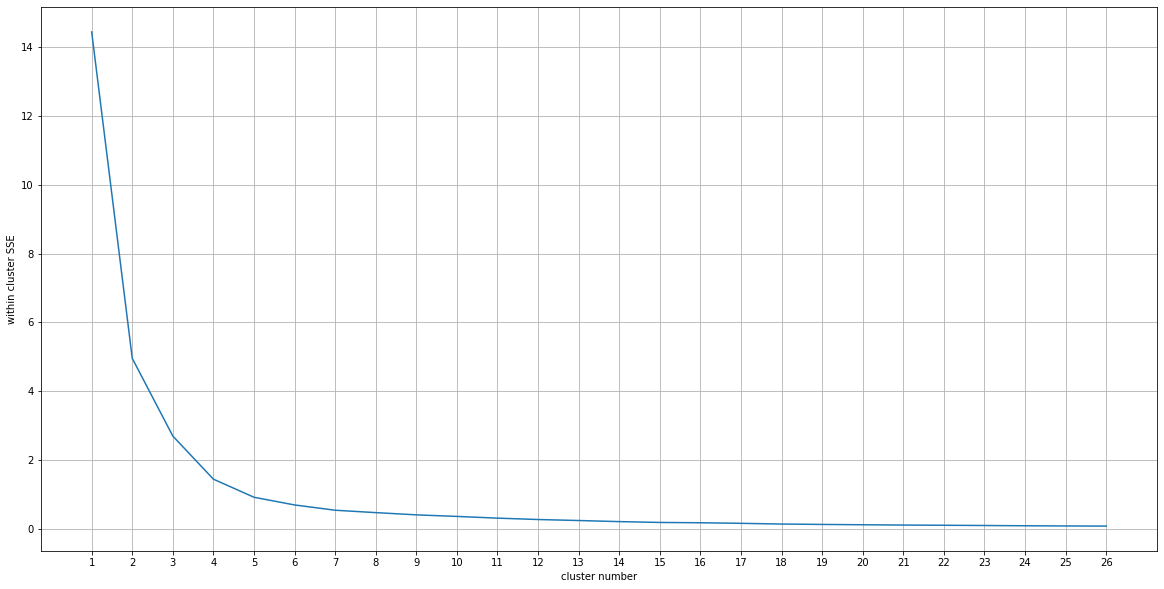

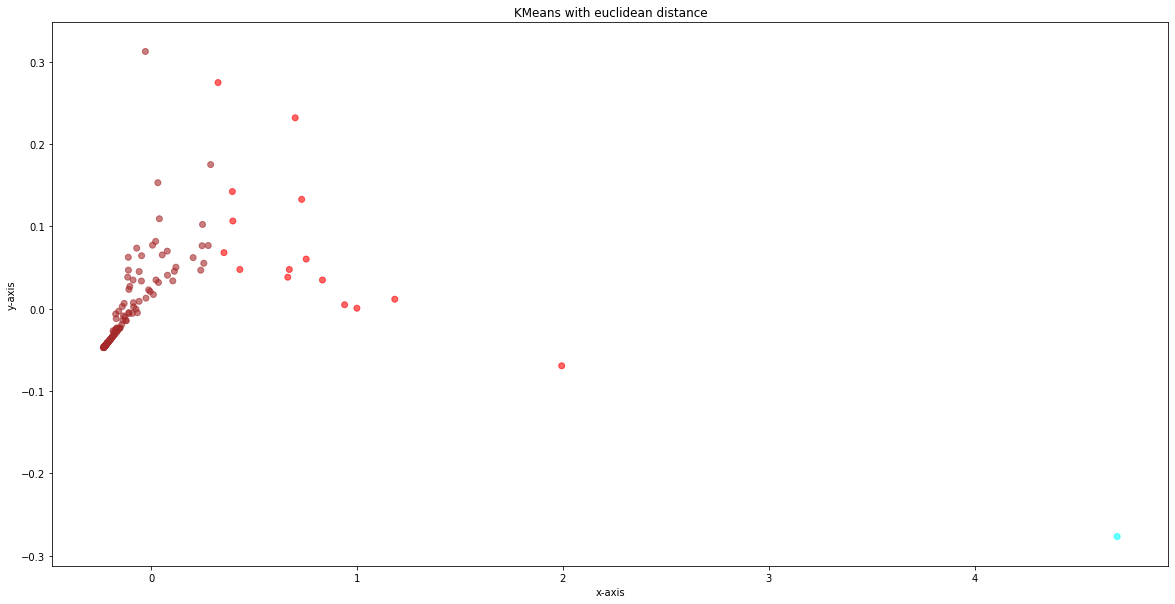

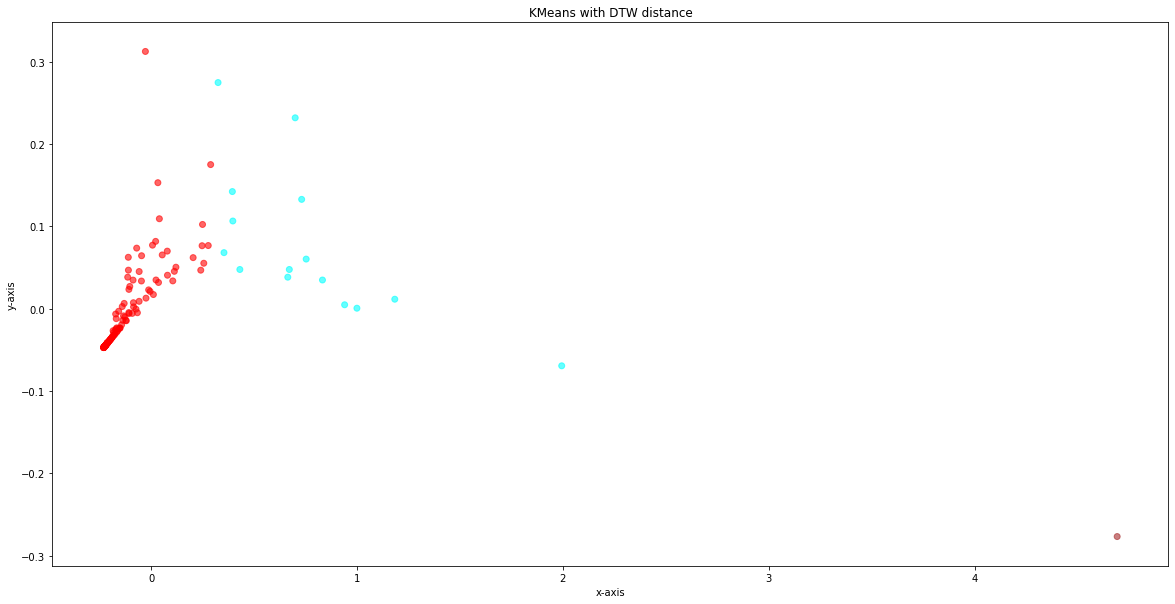

In [194]:
perform_clustering_quarter_wise(4, train)

## Outcome: KMeans with DTW distance does perform better than euclidean distance i.e. Measures based on editing of the time series performed better than shape based distance in the above case. 

# Experiment with spectral clustering..
### 1. First with whole year aggregate data
### 2. Then with quarterly data if the score is not according to the requirement.

In [195]:
wholeYear = copy.deepcopy(train)
perHourElectricityConsumptionEachBuildingWholeYear = wholeYear.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuildingWholeYear.values.copy())

spectralCluster = SpectralClustering(n_clusters=2, n_init=10, assign_labels="discretize", n_jobs=-1, random_state=0, degree=3, affinity="nearest_neighbors")
cluster_found_q1 = spectralCluster.fit_predict(XQ1)
cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
perHourElectricityConsumptionEachBuildingWholeYear.set_index(cluster_found_sr_q1, append=True, inplace=True)

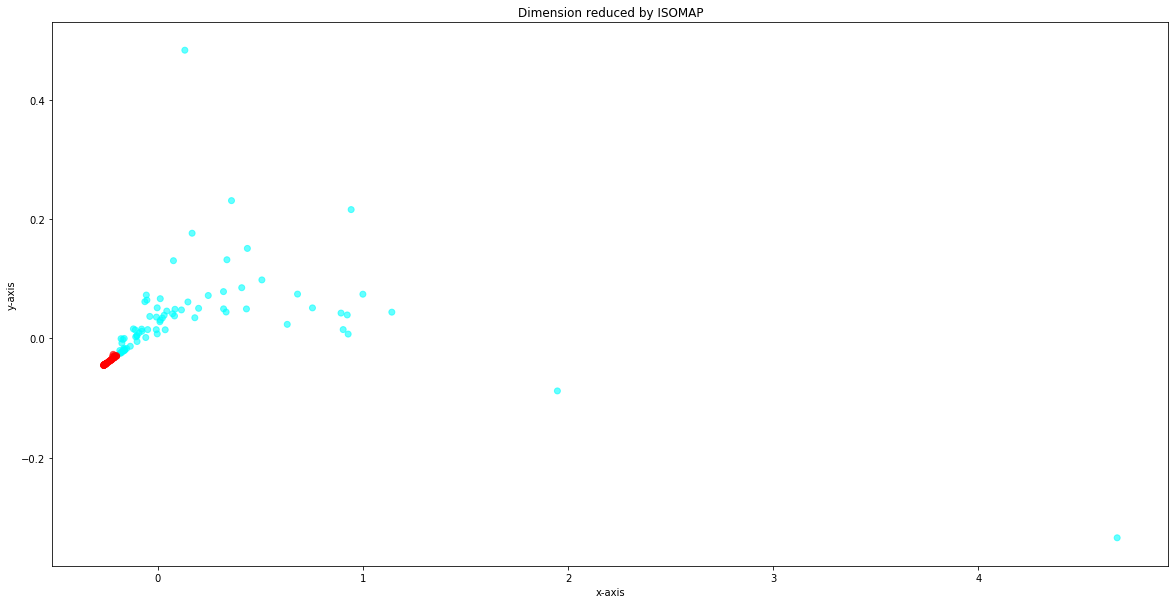

In [196]:
plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingWholeYear, neighbor=10, dimension=2)

In [197]:
print("silhouette score on euclidean metric: ",silhouette_score(XQ1, spectralCluster.labels_))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, spectralCluster.labels_))
print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, spectralCluster.labels_))

silhouette score on euclidean metric:  0.31248045585291345
calsinki-H score on euclidean metric:  31.88400776381737
davis-B score on euclidean metric:  0.888646321357511


In [198]:
def perform_spectral_cluster_quarter_wise(quarter_no=1, ncl  = 8,train=None):
    wholeYear = copy.deepcopy(train)
    if quarter_no>0:
        wholeYear["quarter"] = wholeYear["timestamp"].dt.quarter
        wholeYear = wholeYear[wholeYear["quarter"]==quarter_no]
    wholeYear.fillna(0, inplace=True)
    
    perHourElectricityConsumptionEachBuilding = wholeYear.pivot(values="meter_reading", index="building_id", columns="timestamp")
    perHourElectricityConsumptionEachBuilding.fillna(0, inplace=True)
    XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuilding.values.copy())
    spectralCluster = SpectralClustering(n_clusters=ncl, n_init=10, assign_labels="kmeans", n_jobs=-1,eigen_solver="arpack", )
    print("params: ", spectralCluster.get_params)
    cluster_found_q1 = spectralCluster.fit_predict(XQ1)
    cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
    perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr_q1, append=True, inplace=True)
    plot_isomap(XQ1, perHourElectricityConsumptionEachBuilding, neighbor=8, dimension=2)
    
    print("silhouette score on euclidean metric: ",silhouette_score(XQ1, spectralCluster.labels_))
    print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, spectralCluster.labels_))
    print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, spectralCluster.labels_))
    return 

### Spectral clustering on quarter 1

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric: 

C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


 0.8408798392519187
calsinki-H score on euclidean metric:  43.21844590927664
davis-B score on euclidean metric:  0.10439387919750932


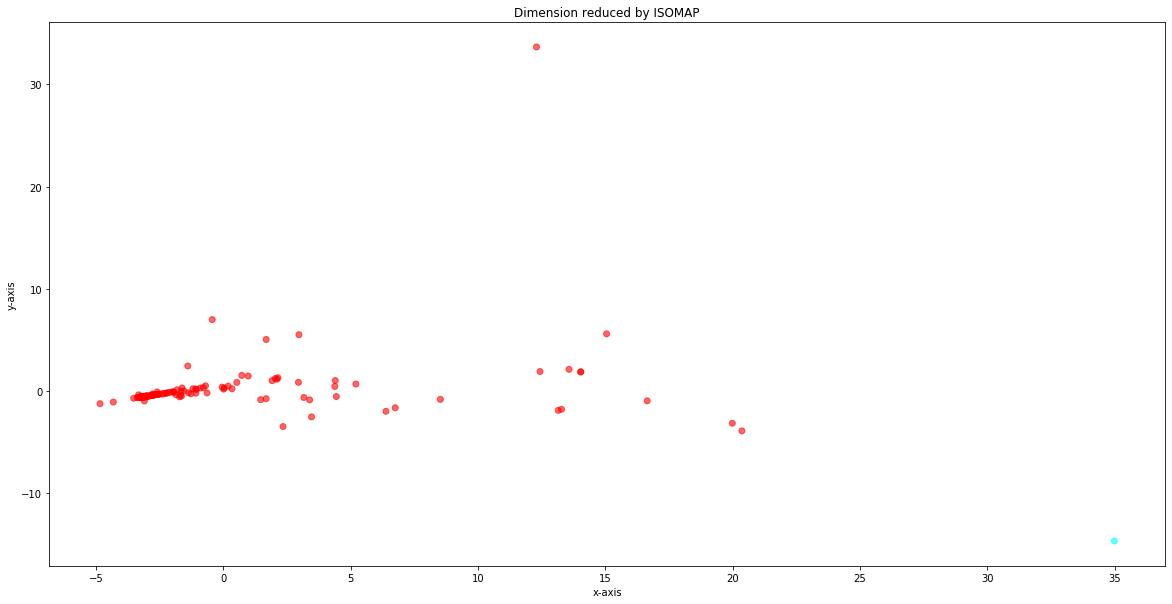

In [199]:
perform_spectral_cluster_quarter_wise(1,2, train)

### Spectral clustering on quarter 2

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric:  0.861973542655692
calsinki-H score on euclidean metric:  59.35238960455332
davis-B score on euclidean metric:  0.09201878243552226


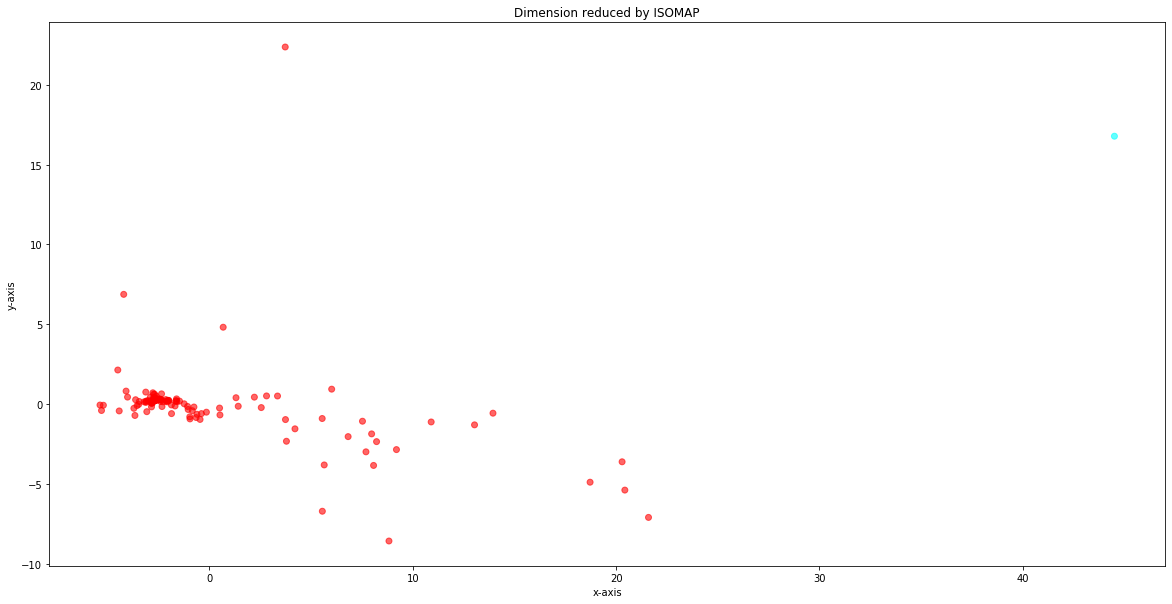

In [200]:
perform_spectral_cluster_quarter_wise(2,2, train)

### Spectral clustering on quarter 3

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric:  0.7990086343801602
calsinki-H score on euclidean metric:  25.947248250615036
davis-B score on euclidean metric:  0.13499720690255995


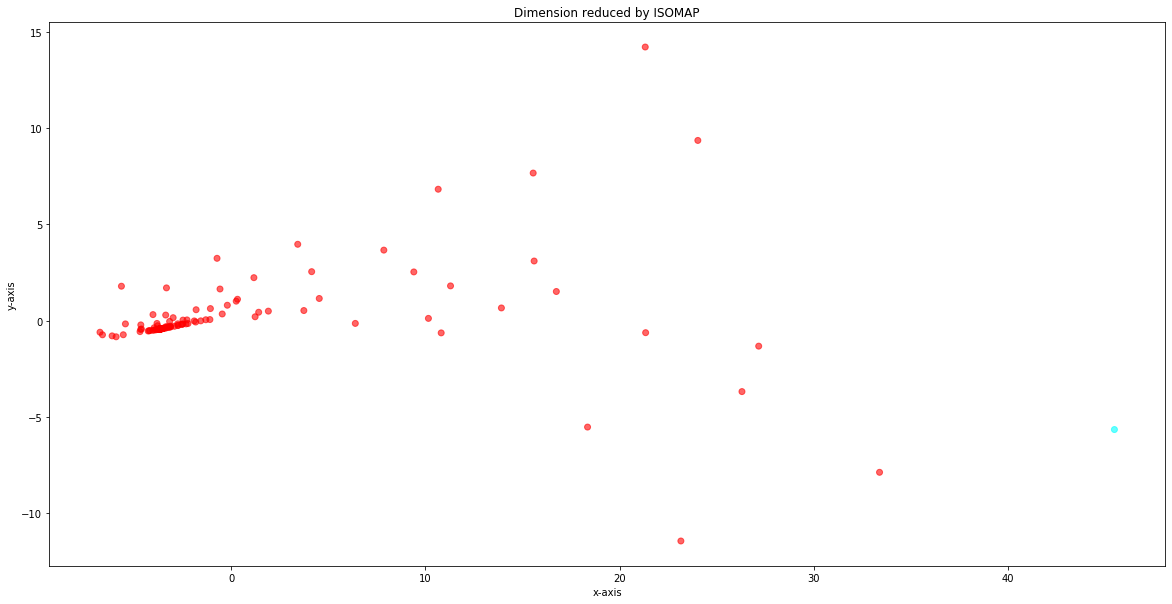

In [201]:
perform_spectral_cluster_quarter_wise(3,2, train)

### Spectral clustering on quarter 4

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric:  0.7779792668152694
calsinki-H score on euclidean metric:  15.598889651274455
davis-B score on euclidean metric:  0.1562844997798304


C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


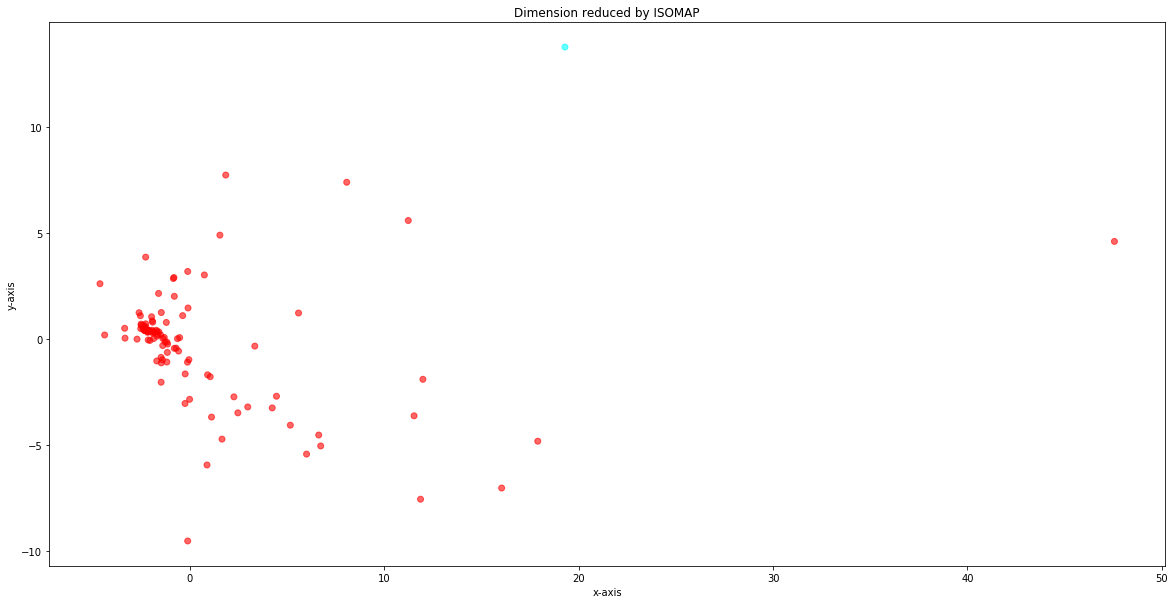

In [202]:
perform_spectral_cluster_quarter_wise(4,2, train)

### Spectral clustering on whole year - function testing part - can be ignored

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=8, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>


C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  n_init=n_init)


silhouette score on euclidean metric:  0.7391679037044919
calsinki-H score on euclidean metric:  12.463234953879462
davis-B score on euclidean metric:  0.1925587837589305


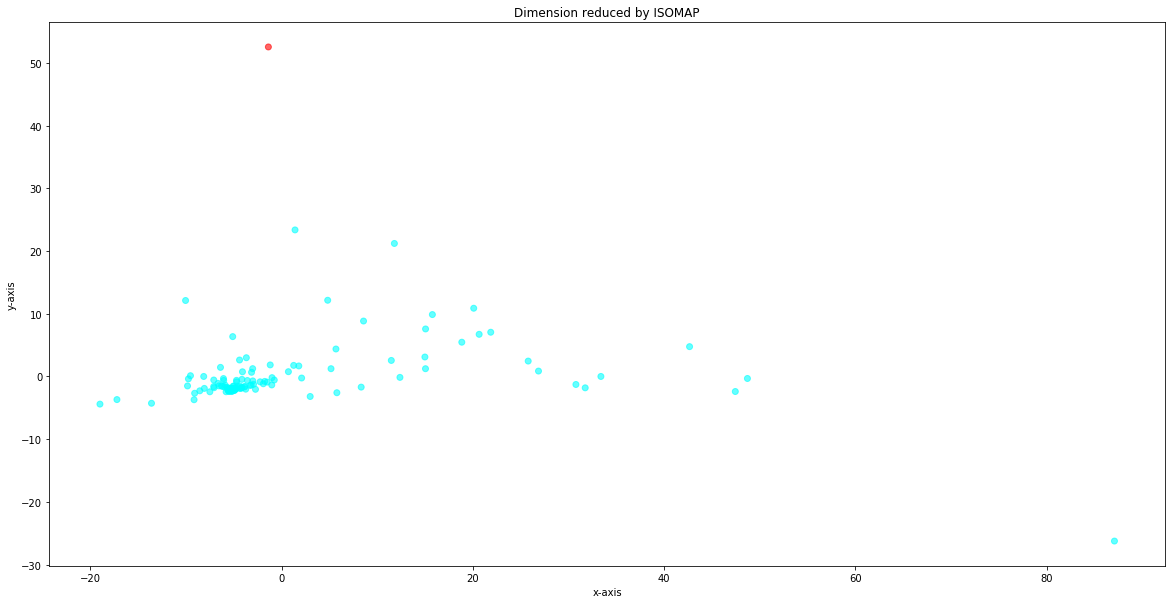

In [203]:
perform_spectral_cluster_quarter_wise(0, train=train)

### Perform Agglomerative clustering and see if any pattern can be extracted.

In [204]:
def plot_scipy_edndogram(pivot=None):
    z = sch.linkage(MinMaxScaler().fit_transform(pivot.values),"ward")
    plt.figure(figsize=(20,10))
    a = sch.dendrogram(z, show_leaf_counts=False,leaf_font_size=12.,show_contracted=True, leaf_rotation=90)
    return

def performAgglomerativeClustering(ncl = 2, affinity="euclidean", linkage="ward", X=None, pivot=None):
    AGModel = AgglomerativeClustering(n_clusters=ncl,affinity=affinity, linkage=linkage)
    x = MinMaxScaler().fit_transform(X)
    cluster_found = AGModel.fit_predict(x)
    #pivot.set_index("building_id", inplace=True)
    cluster_found = pd.Series(cluster_found, name="cluster")
    pivot.set_index(cluster_found, append=True, inplace=True)
    print("silhouette sample on euclidean metric: ",silhouette_samples(x, cluster_found))
    print("silhouette score on euclidean metric: ",silhouette_score(x, cluster_found))
    print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(x, cluster_found))
    print("davis-B score on euclidean metric: ",davies_bouldin_score(x, cluster_found))
    plot_isomap(x, pivot)
    plot_kernel_pca(x, pivot=pivot, kernel="rbf", g=15,rzev=True, deg = 1)
    plot_tsne(x, pivot)
    plot_umap(x, pivot)
    return pivot

def generate_dtw_matrix(pivot=None):
    from dtaidistance import dtw
    mat = dtw.distance_matrix(pivot)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if i == j:
                mat[i,j] = 0
            else:
                mat[j,i] = mat[i,j]
    return mat

def generate_quarter_pivot_matrix(quarter_no = 0,pivot=None):
    quarter1 = copy.deepcopy(train)
    if quarter_no>0:
        quarter1["quarter"] = quarter1["timestamp"].dt.quarter
        quarter1 = quarter1[quarter1["quarter"]==quarter_no]
    quarter1["meter_reading"].fillna(0, inplace=True)
    
    if quarter_no>0:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    else:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot(values="meter_reading", index="building_id", columns="timestamp")
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    return perHourElectricityConsumptionEachBuildingQ1

In [205]:
aggTrain = copy.deepcopy(train)

### Pivot over whole year data

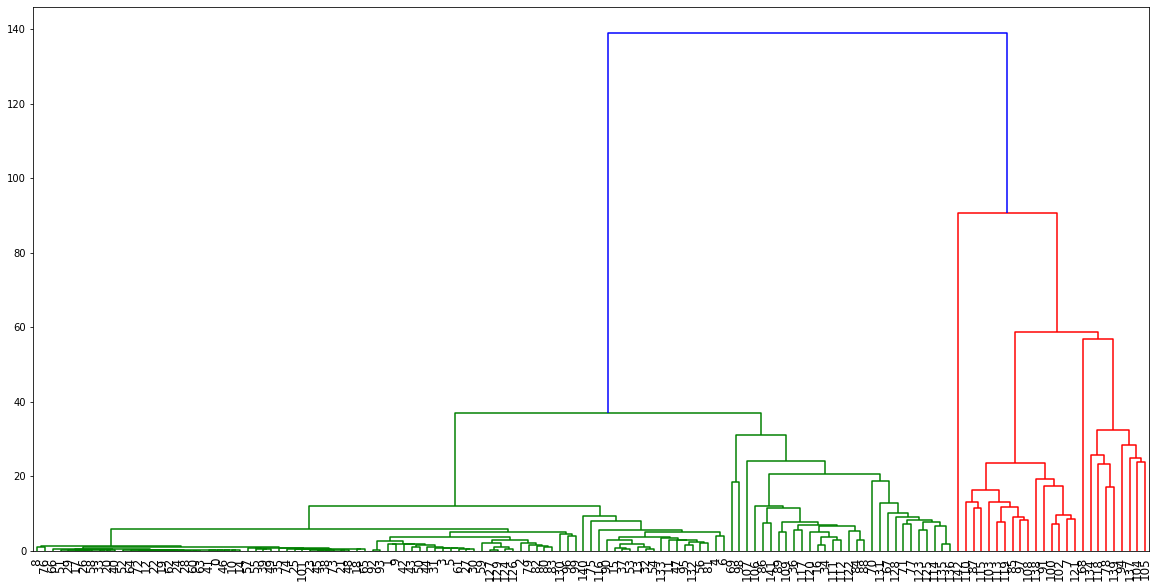

In [206]:
pivot = generate_quarter_pivot_matrix(0,aggTrain)
plot_scipy_edndogram(pivot = pivot)

silhouette sample on euclidean metric:  [ 0.87839477  0.86164871  0.85424898  0.87444684  0.80431173  0.87716646
  0.77679625 -0.48139403  0.87278383  0.86583515  0.87839323  0.83316188
  0.87753573  0.8506413   0.87865018  0.84706155  0.70790288  0.87819171
  0.87748247  0.87752648  0.87779097  0.87939641  0.87833888  0.87912534
  0.87790735  0.87924253  0.87877596  0.8775879   0.87769082  0.87818362
  0.87838105  0.87463466  0.85854136  0.87797038  0.73562886  0.8761638
  0.54967394  0.83856611  0.87953099  0.87763708  0.87770892  0.87876145
  0.86053523  0.87034627  0.87018921  0.87950023  0.87781674  0.83005056
  0.88000643  0.87836001  0.87016984  0.87914974  0.8766526   0.83470789
  0.86646072  0.87896227  0.84339054  0.87609276  0.87943733  0.86077472
  0.87783488  0.87457026  0.87739934  0.87788329  0.87705212  0.87801136
  0.87555403  0.59814747  0.01520685  0.14272896  0.45201848  0.73654167
  0.87719551  0.87907012  0.87781117  0.74830271  0.87329612  0.6901122
  0.27143134 

,timestamp,2016-01-01 00:00:00,2016-01-01 01:00:00,2016-01-01 02:00:00,2016-01-01 03:00:00,2016-01-01 04:00:00,2016-01-01 05:00:00,2016-01-01 06:00:00,2016-01-01 07:00:00,2016-01-01 08:00:00,2016-01-01 09:00:00,...,2016-12-31 14:00:00,2016-12-31 15:00:00,2016-12-31 16:00:00,2016-12-31 17:00:00,2016-12-31 18:00:00,2016-12-31 19:00:00,2016-12-31 20:00:00,2016-12-31 21:00:00,2016-12-31 22:00:00,2016-12-31 23:00:00
building_id,cluster,,,,,,,,,,,,,,,,,,,,,
106,1,0.000,10.0000,10.000,10.000,0.000,20.000,10.000,10.000,20.000,10.000,...,10.0000,0.000,10.000,0.000,0.0000,10.0000,0.000,0.000,10.000,0.000
109,1,0.000,0.0000,100.000,0.000,0.000,0.000,0.000,100.000,0.000,100.000,...,0.0000,0.000,0.000,0.000,100.0000,0.0000,0.000,0.000,0.000,0.000
112,1,96.978,93.6492,186.351,190.000,100.000,180.000,190.000,90.000,280.000,190.000,...,90.0000,0.000,90.000,0.000,0.0000,90.0000,0.000,0.000,90.000,0.000
113,1,19.597,30.0000,30.000,30.000,30.000,30.000,30.000,30.000,20.000,30.000,...,34.9248,30.000,30.000,30.000,30.0000,30.0000,30.000,30.000,30.000,30.000
114,1,100.000,300.0000,300.000,300.000,300.000,300.000,300.000,400.000,400.000,400.000,...,300.1440,299.664,300.186,300.066,299.6590,299.8630,300.058,253.326,300.000,246.577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,0,1380.940,1495.6800,1462.170,1393.040,1496.670,1650.470,1524.740,1504.120,1436.090,1555.770,...,2736.0200,2530.060,2715.950,2539.720,2561.5600,2378.9100,2590.960,2702.250,2588.090,2476.610
1323,0,1407.920,1330.8800,1503.050,1451.960,1046.950,1274.790,1274.770,1268.230,1445.070,1250.600,...,2782.5000,2702.910,1293.210,1616.500,1678.2200,1492.0800,1771.050,1856.020,1846.670,1909.330
1324,1,0.000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,920.2640,779.894,745.906,139.033,72.6696,30.1301,142.702,129.675,120.251,364.019


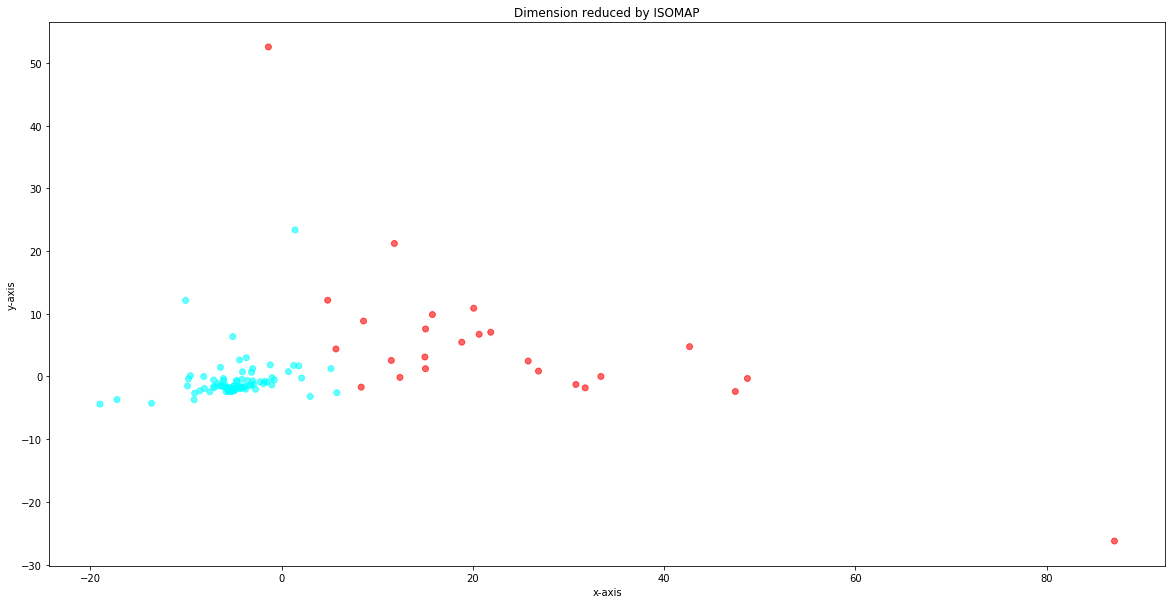

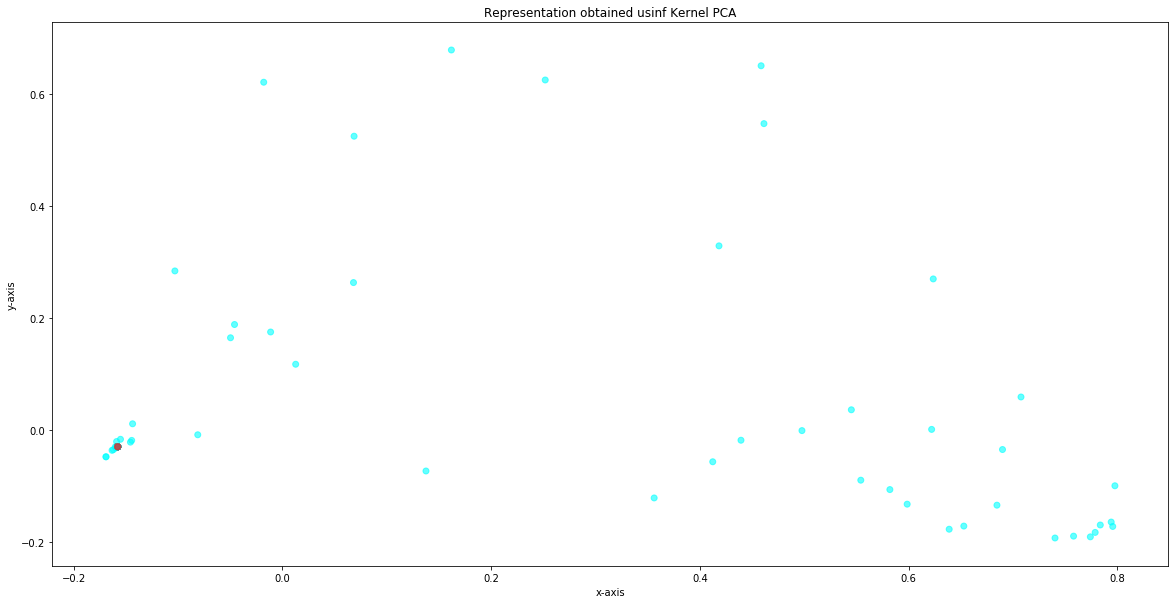

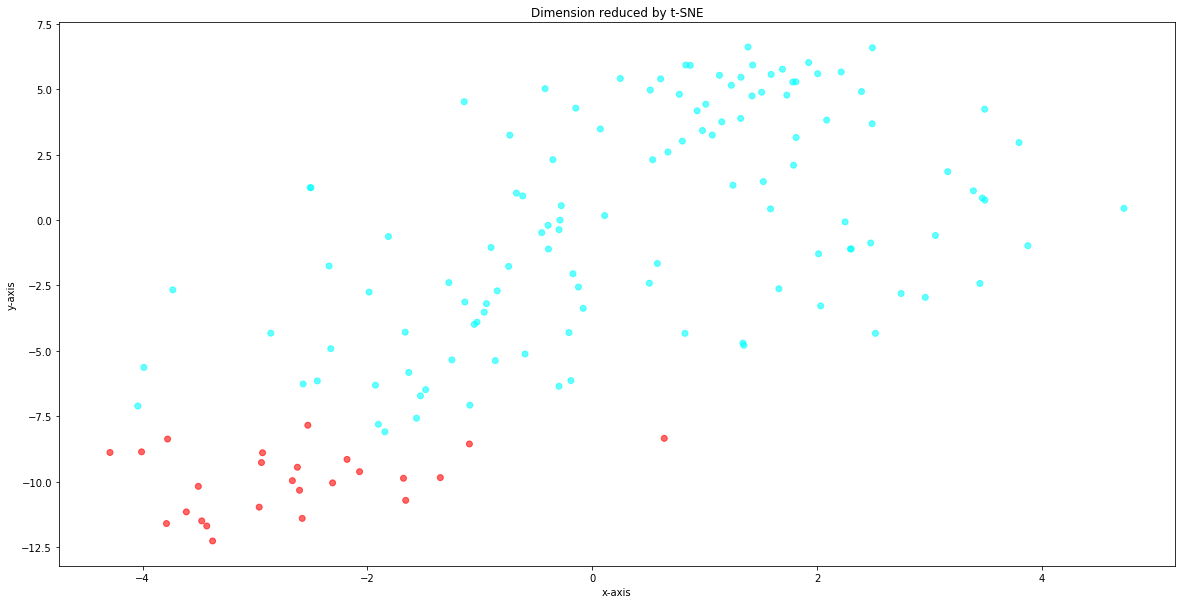

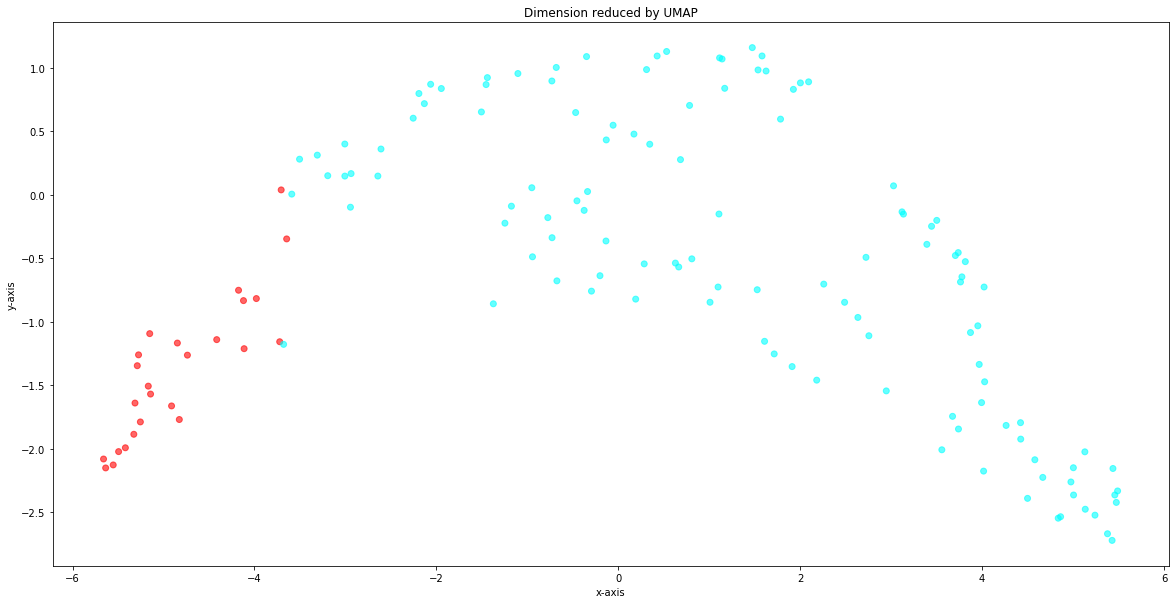

In [207]:
performAgglomerativeClustering(ncl=2, X=pivot.values, pivot=pivot)

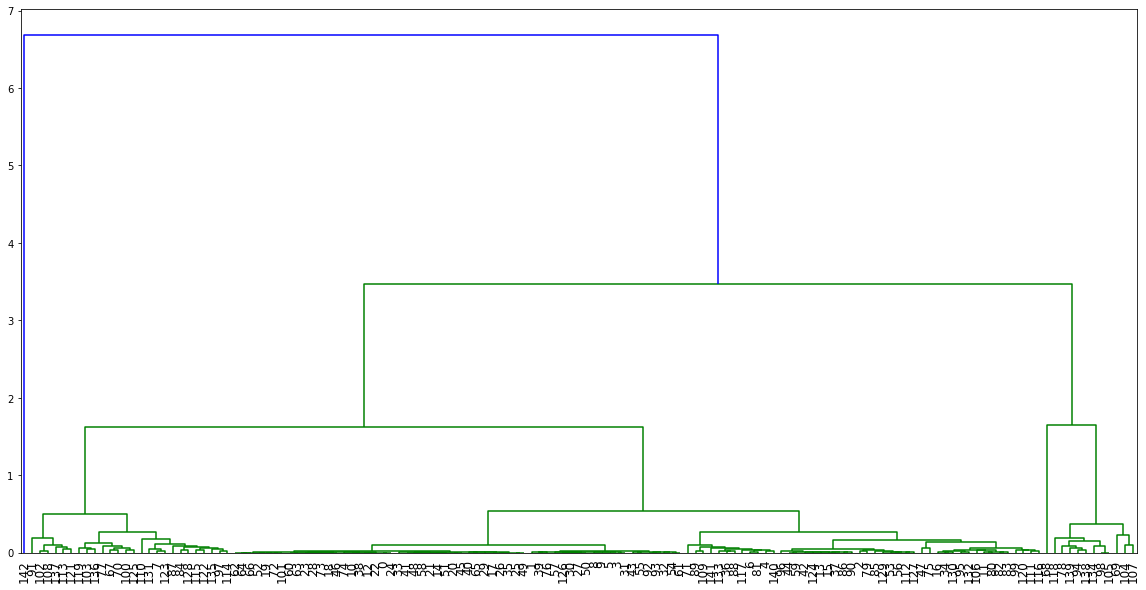

In [208]:
pivot = generate_quarter_pivot_matrix(1,aggTrain)
plot_scipy_edndogram(pivot = pivot)


silhouette sample on euclidean metric:  [0.96789279 0.96894191 0.96937359 0.96964046 0.9671904  0.96944952
 0.9677681  0.95103904 0.969394   0.96952618 0.96788839 0.96997139
 0.96786116 0.97022663 0.96805528 0.97025134 0.96888953 0.96843411
 0.96778688 0.96744472 0.96815466 0.96811917 0.96789977 0.9676565
 0.96776798 0.96874295 0.96860562 0.96936175 0.96761928 0.96870949
 0.96930652 0.96961404 0.96992248 0.96814453 0.96910885 0.96848081
 0.96554928 0.97032421 0.96790671 0.96927165 0.96799954 0.96841509
 0.97011667 0.96990728 0.97032943 0.96812851 0.967698   0.96604552
 0.96827112 0.9686552  0.96942893 0.96815957 0.96749451 0.97023188
 0.96979289 0.96983591 0.97019579 0.96915839 0.96831576 0.97033419
 0.96758406 0.96971296 0.96728082 0.9675469  0.96726542 0.96847391
 0.96726542 0.94269982 0.39029469 0.78795226 0.94041023 0.95976222
 0.96735226 0.96764604 0.96776507 0.95975457 0.96905688 0.93911966
 0.85648982 0.96958692 0.97000375 0.96673315 0.96960804 0.96954498
 0.96143467 0.96998604 

,hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
building_id,cluster,,,,,,,,,,,,,,,,,,,,,
106,0,4.574112,3.693738,4.244162,3.821100,4.159203,5.041580,18.893641,13.444534,13.394921,18.218901,...,14.487569,13.469134,14.749933,13.157805,12.974757,10.069767,10.361977,10.193632,4.558893,4.037519
109,0,23.199632,25.385386,22.340676,24.588981,35.505268,29.437126,21.532513,30.532830,42.623254,51.712142,...,49.878097,58.422860,50.064487,61.637237,37.798712,24.880464,50.417984,28.837652,14.493952,29.114875
112,0,77.095913,64.967577,69.329204,63.390742,73.267148,71.705822,202.328404,142.727786,166.438427,252.644968,...,189.516166,174.464945,194.918327,173.888236,153.628163,121.929789,128.892123,111.624692,74.643271,67.592387
113,0,59.320762,58.438229,59.061816,58.533047,58.316711,57.984936,58.930574,58.434686,56.205162,55.059884,...,67.319060,67.418345,67.330351,67.522151,67.125926,62.674633,61.831684,60.824305,60.809129,60.261522
114,0,281.360385,283.189945,291.649220,290.148341,294.947648,302.256582,303.535220,401.144516,361.659923,371.223462,...,314.974033,316.003418,305.130703,316.179835,303.304725,300.571736,307.187385,287.860319,290.834901,281.330198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,0,1949.664890,1872.530462,1907.675231,1841.438473,1862.798692,1890.751956,1867.397429,1940.235451,1928.651407,1978.564165,...,1985.942495,1979.652069,1928.449910,1905.076846,1821.334822,1730.295141,1690.729560,1686.898848,1758.894863,1740.592189
1323,0,1768.430165,1871.439802,1875.681593,1860.930604,1632.115440,1681.817000,1703.243275,1691.330714,1718.466505,1705.136604,...,2128.938901,1963.048462,1800.471791,1735.702967,1690.097549,1649.793912,1632.303956,1649.186253,1730.044385,1708.865066
1324,0,274.913856,291.507163,293.607056,300.179224,310.150907,321.265682,317.029427,334.235130,343.580152,338.012363,...,404.371735,370.634342,319.388637,328.412041,311.806262,293.562512,263.907286,267.038073,251.807010,243.714703


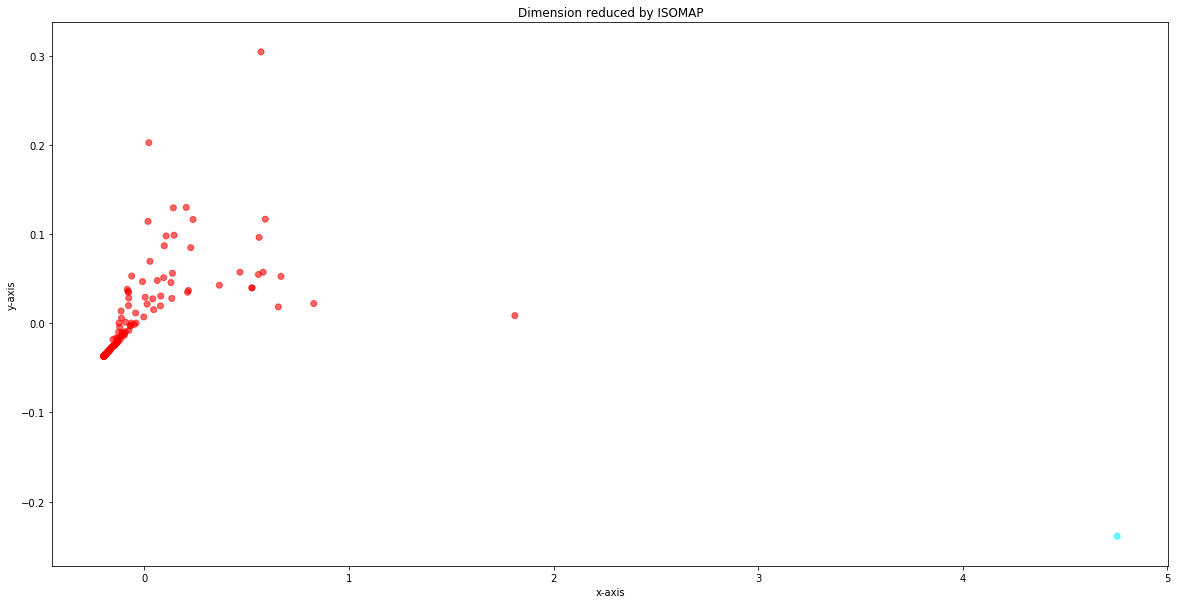

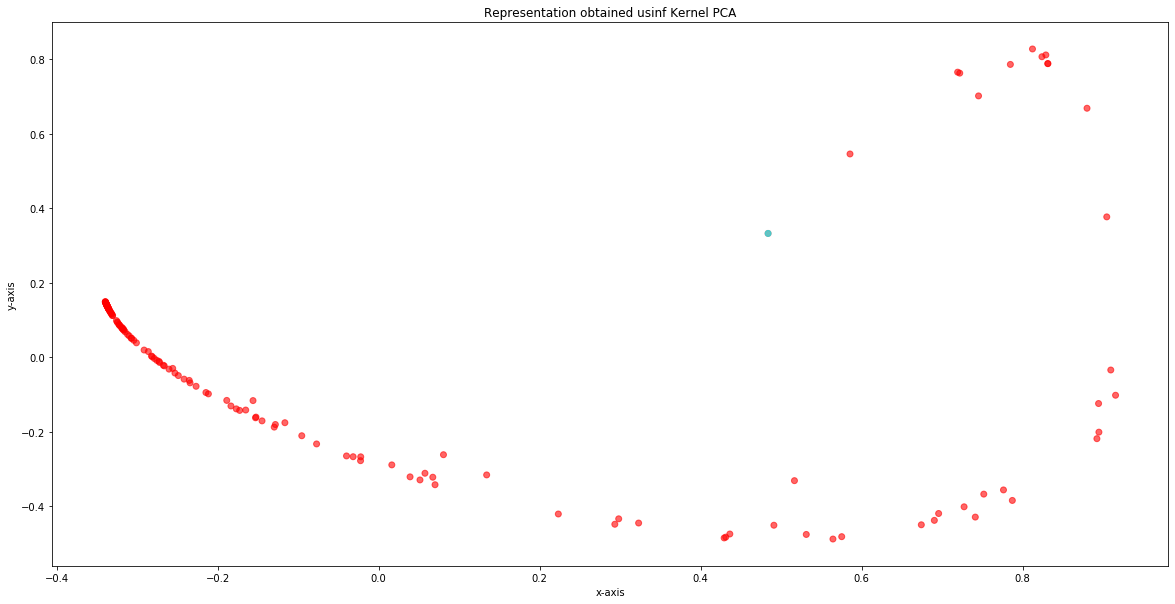

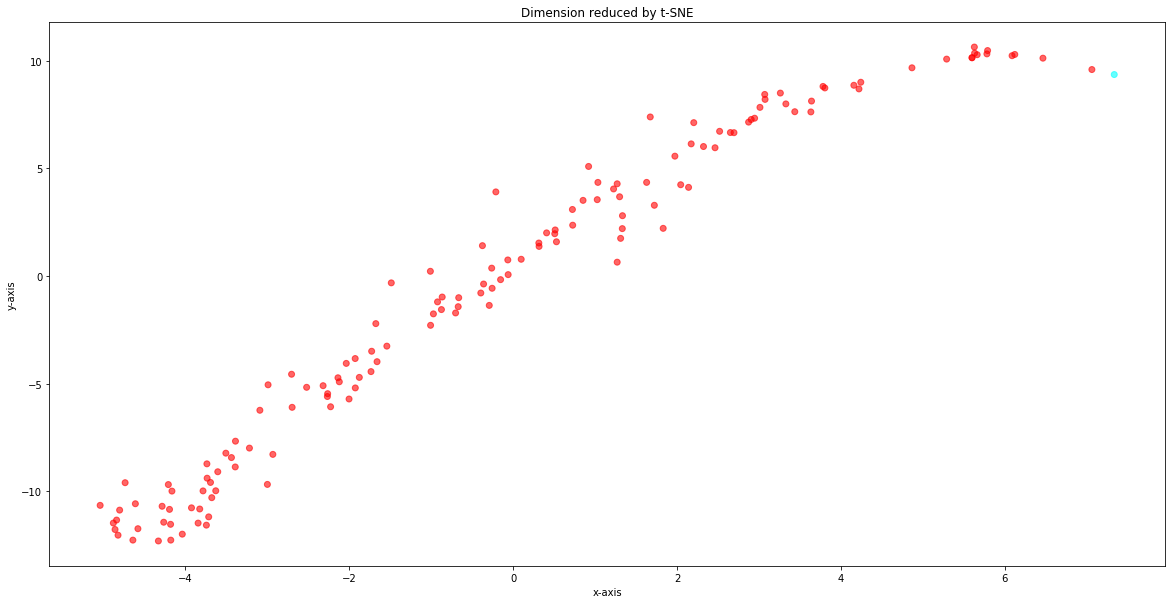

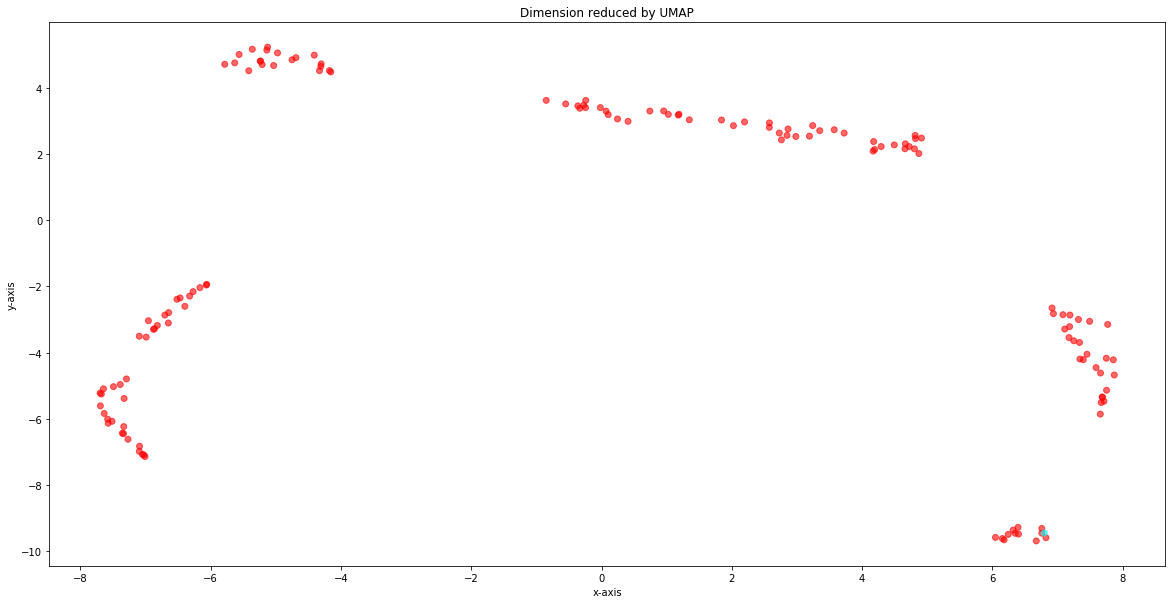

In [209]:
performAgglomerativeClustering(ncl=2, X=pivot.values, pivot=pivot)

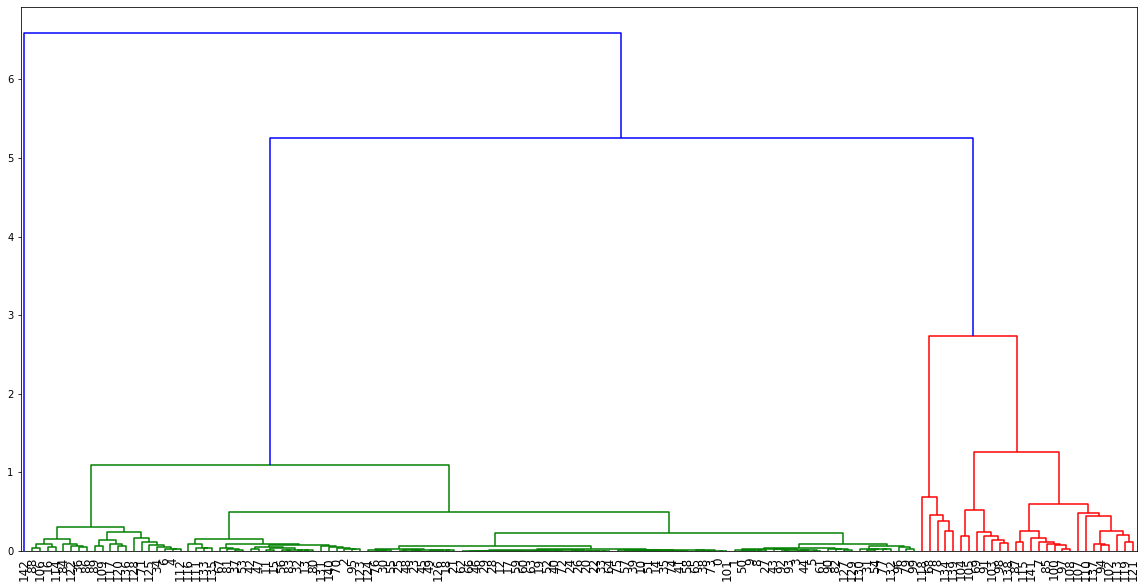

In [210]:
pivot = generate_quarter_pivot_matrix(2,aggTrain)
plot_scipy_edndogram(pivot = pivot)


silhouette sample on euclidean metric:  [ 0.91539409  0.9178936   0.88821563  0.91818175  0.80308703  0.91811526
  0.8121908  -0.16789266  0.91916275  0.91892065  0.91405148  0.88960685
  0.91132394  0.9045116   0.91403125  0.89227776  0.68274433  0.91132394
  0.91581136  0.91152357  0.91250871  0.91642147  0.91245106  0.91678769
  0.91201668  0.91800111  0.91228342  0.91928745  0.91132394  0.91132394
  0.91854515  0.91507194  0.90762254  0.91267038  0.76302941  0.91378303
  0.52206854  0.87124538  0.91538     0.91394869  0.91147039  0.91440815
  0.89894257  0.91516605  0.91823623  0.91731893  0.91132394  0.89729592
  0.91805255  0.91740263  0.9177837   0.91387427  0.91154567  0.87706207
  0.91221497  0.91896601  0.89846998  0.91288895  0.91379815  0.91138515
  0.91140643  0.91784249  0.91200009  0.91159857  0.91278061  0.91479285
  0.91137916  0.87203028  0.39734947  0.47519922  0.88250873  0.74673827
  0.91146189  0.91539133  0.9150581   0.9125165   0.91810406  0.91411337
  0.3920768

,hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
building_id,cluster,,,,,,,,,,,,,,,,,,,,,
106,2,3.639304,4.063010,4.217056,4.311929,4.030986,9.571452,6.788738,6.963702,8.562131,7.928767,...,6.495731,6.273582,6.343362,5.958734,5.825178,5.407908,5.112874,3.690333,3.495314,4.382591
109,2,32.333540,24.088857,22.625790,16.511300,28.121733,22.101300,21.961149,18.589353,38.725974,47.211873,...,27.753378,38.667932,34.448157,29.670924,31.598692,23.389864,31.517232,18.825590,22.198705,15.251990
112,2,51.435382,67.080335,66.295077,62.649584,63.515799,107.061018,90.229490,98.219435,109.616580,109.837615,...,85.313554,82.471689,83.463887,84.730363,72.464847,77.251745,64.635918,61.593918,56.384641,64.086799
113,2,33.344774,32.922549,32.553231,32.744040,32.270590,32.248903,33.684714,32.809946,34.213956,33.643796,...,37.619688,37.744442,37.494773,37.836869,36.800629,36.166858,34.209734,35.430871,32.809357,33.118048
114,2,146.038952,153.786685,150.591044,164.824360,159.814154,164.543838,177.190938,201.109104,196.149341,173.594795,...,128.772500,148.961411,132.481684,142.856626,130.793307,126.076977,130.253363,131.143731,126.855964,145.014988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,0,684.951815,737.947618,701.432701,621.912296,772.214857,761.442544,922.417176,721.851143,831.862626,747.037678,...,711.924386,630.953581,718.781180,642.580990,545.024741,508.491555,630.742409,486.469019,483.601458,493.375176
1323,0,1306.799198,1314.772637,1322.015451,1150.373231,1166.349352,1163.227544,1149.942545,1165.402264,1199.296681,1213.212066,...,1369.414989,1332.008791,1270.890154,1294.895495,1289.225857,1269.067802,1257.267088,1246.416363,1249.954440,1276.552044
1324,2,35.792224,33.961054,43.975207,51.863697,80.891363,88.879958,91.085118,121.642808,126.857576,97.551182,...,77.392388,118.461475,68.572590,54.233611,29.001460,17.406942,42.580435,52.010485,23.419391,36.249591


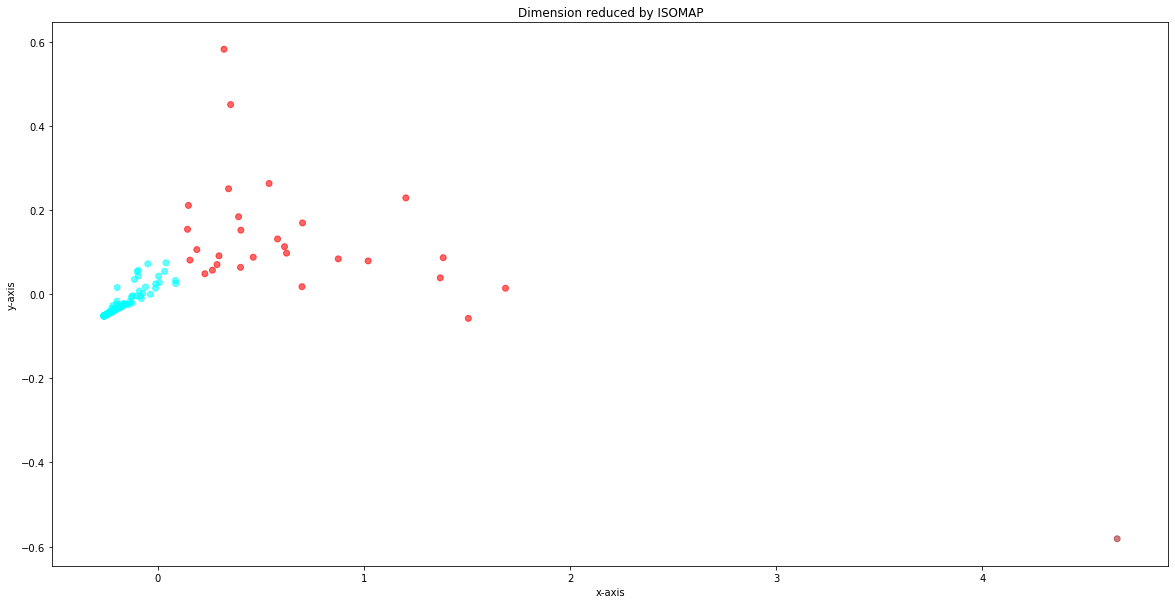

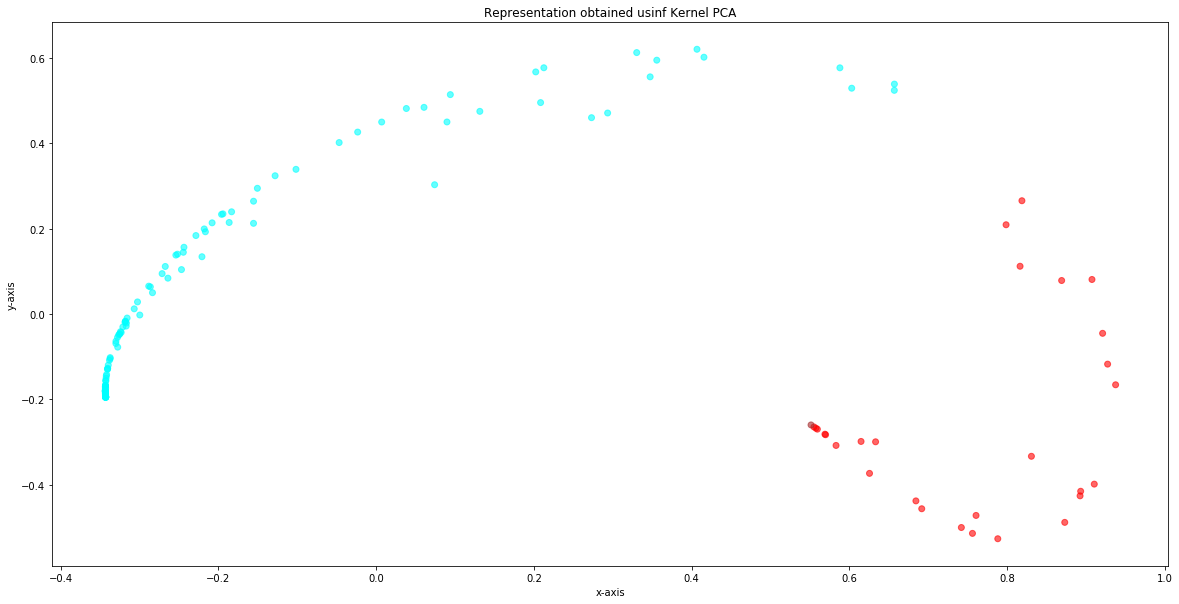

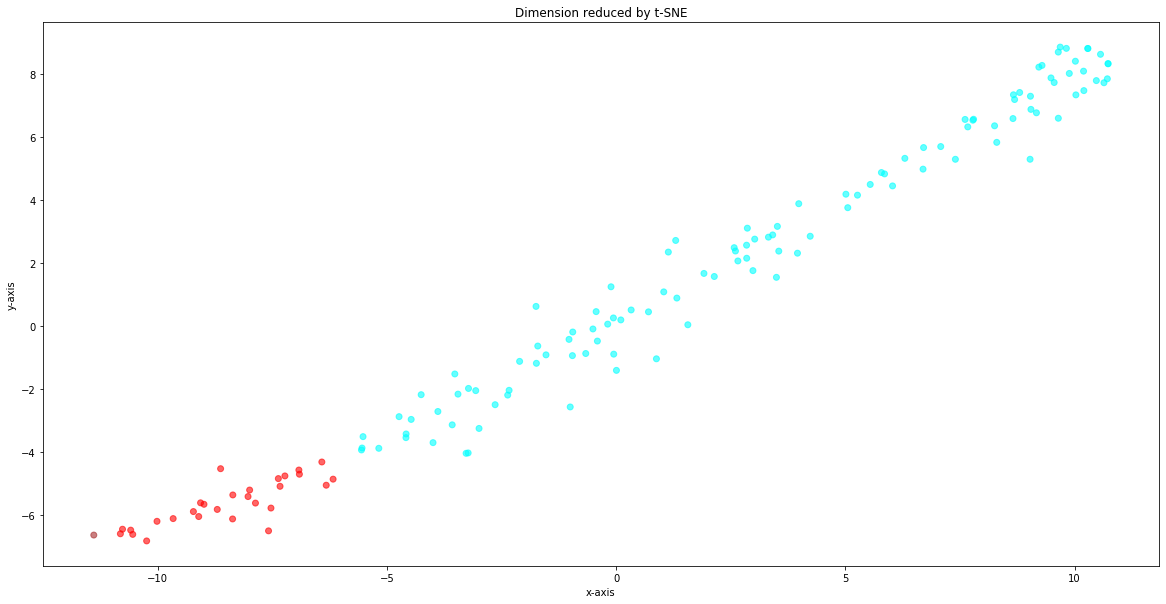

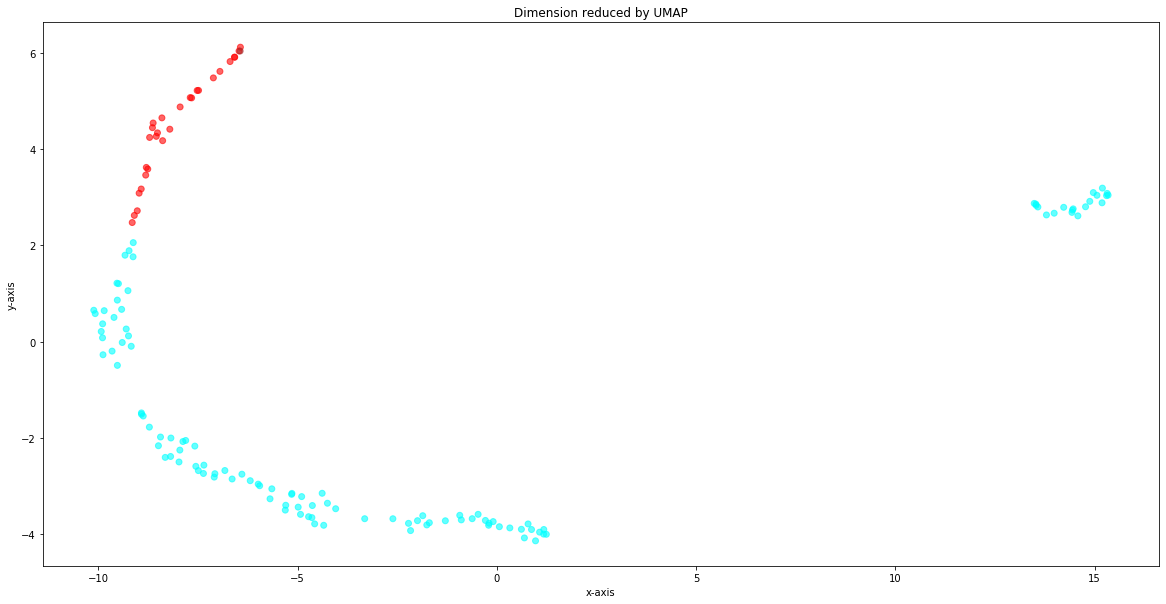

In [211]:
performAgglomerativeClustering(ncl=3, X=pivot.values, pivot=pivot)

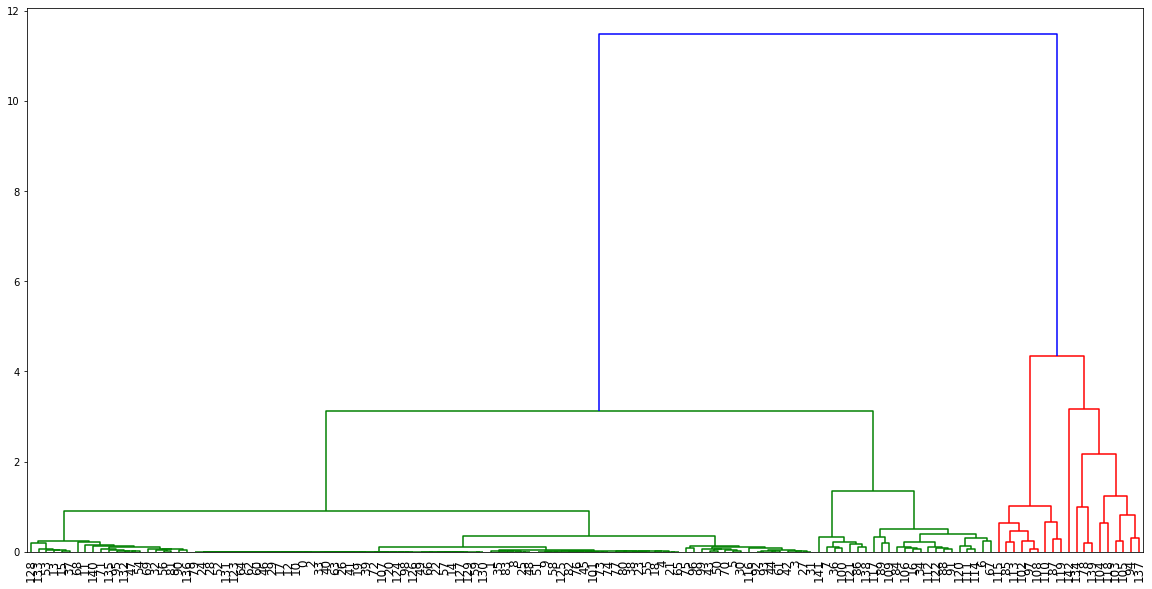

In [212]:
pivot = generate_quarter_pivot_matrix(3,aggTrain)
plot_scipy_edndogram(pivot = pivot)


silhouette sample on euclidean metric:  [ 0.92847703  0.92989065  0.92847703  0.92592813  0.93036269  0.92912023
  0.82709096  0.5663572   0.9304666   0.92925758  0.92847703  0.90054724
  0.92847703  0.89385864  0.92884142  0.89189822  0.72991054  0.92847703
  0.93020018  0.92850987  0.92855958  0.93034879  0.92872171  0.93048153
  0.92848087  0.9302645   0.92848765  0.92695499  0.92847778  0.92847703
  0.92785932  0.92683456  0.9025039   0.92857415  0.75637618  0.9299854
  0.50341679  0.8856924   0.93045406  0.92850641  0.92850935  0.92850116
  0.92442172  0.926006    0.92183527  0.93014987  0.92847703  0.91613145
  0.93041194  0.92855716  0.92377949  0.92971102  0.92847802  0.8774632
  0.91421462  0.93052342  0.90841701  0.92871784  0.9297153   0.92882414
  0.92847703  0.92411253  0.92847703  0.92851272  0.92847703  0.93048026
  0.92911191  0.81519406  0.88348797  0.89575679  0.92589677  0.91391187
  0.92852245  0.93027719  0.93015005  0.90890667  0.92969137  0.92789995
  0.5436139  

,hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
building_id,cluster,,,,,,,,,,,,,,,,,,,,,
106,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
109,1,7.181923,8.035468,5.434783,9.667338,8.810923,6.521739,9.729171,5.176372,4.659675,11.956522,...,3.451228,11.675221,10.256064,4.347826,8.695652,10.802226,8.762991,3.260870,10.869565,3.260870
112,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
113,1,24.039220,24.361525,24.253101,24.052380,23.782248,24.712524,25.025204,24.864364,24.055023,25.350279,...,26.812123,27.484165,28.279607,26.648585,26.149551,25.182733,25.025626,24.078497,24.382778,24.293511
114,1,6.521740,7.608696,8.426355,6.523435,7.778320,8.693261,7.600251,11.644379,4.666528,8.797898,...,5.447846,7.690867,5.434783,6.521739,3.260870,7.608696,6.410036,6.527847,6.405803,5.656314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,1,263.479096,266.812392,273.474054,216.097975,255.424105,280.638278,279.100745,349.107301,311.987430,295.883776,...,292.808452,258.910378,255.409654,263.773134,307.351265,224.168375,227.653784,283.111666,278.820901,202.094109
1323,0,956.250946,991.893250,987.628315,820.877489,838.033609,830.756359,828.472163,839.903440,848.604652,853.466641,...,1003.729217,1017.019261,1001.708326,967.290630,943.887315,959.200217,906.761848,929.263967,936.201272,955.544087
1324,1,47.033418,35.893226,57.665417,49.413909,95.171335,60.007189,57.530579,112.654680,85.910809,81.518624,...,51.728286,70.286541,32.297486,15.724637,19.399323,8.070816,23.783793,29.866559,23.792411,37.334883


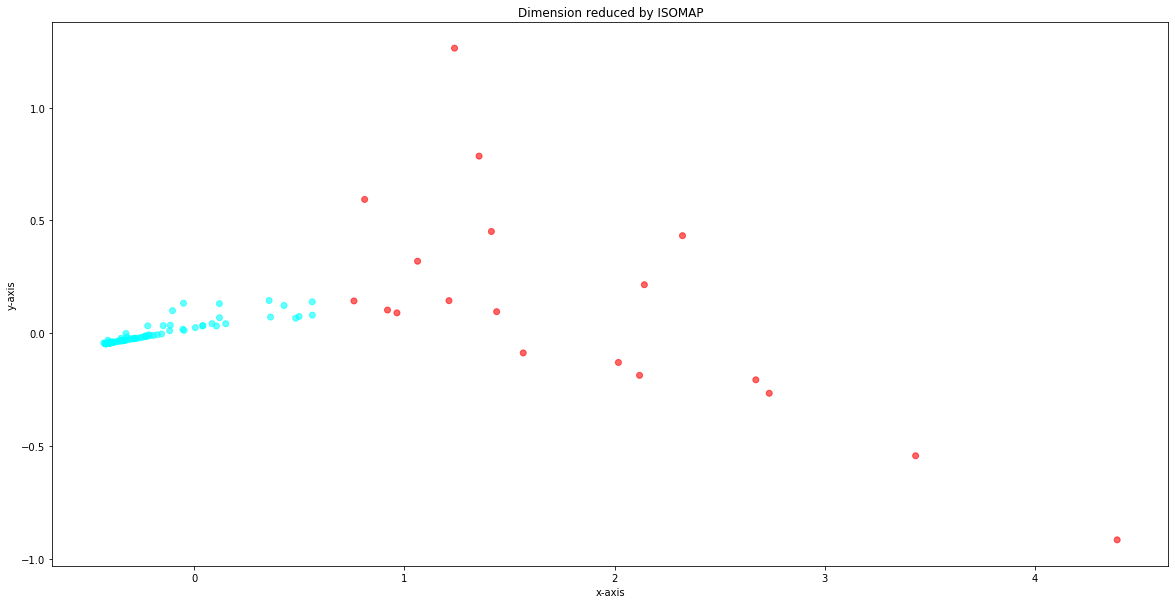

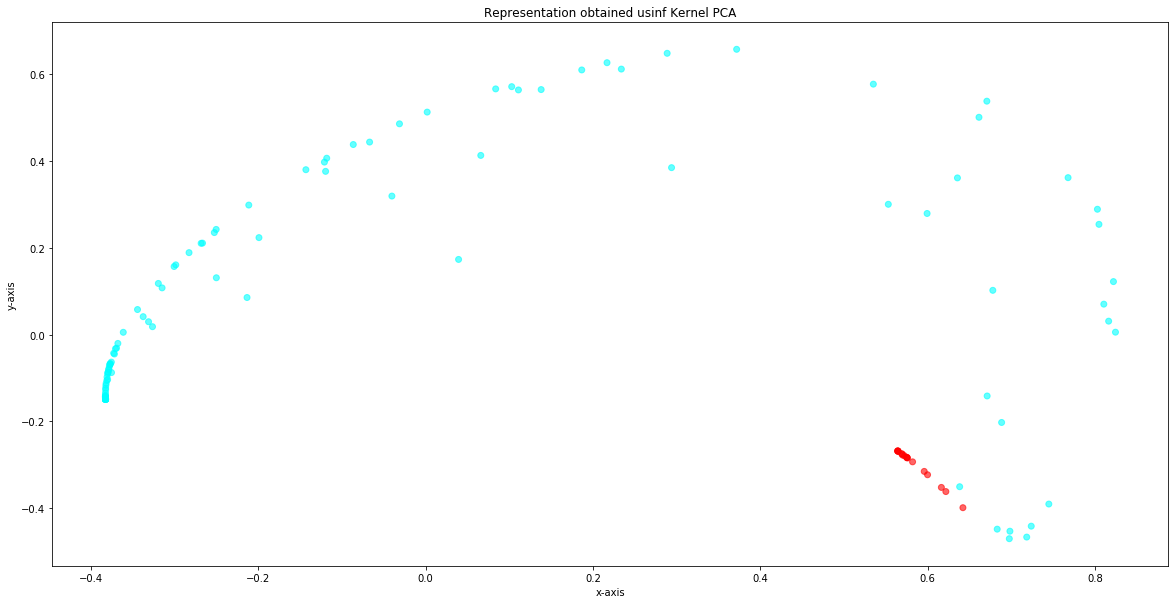

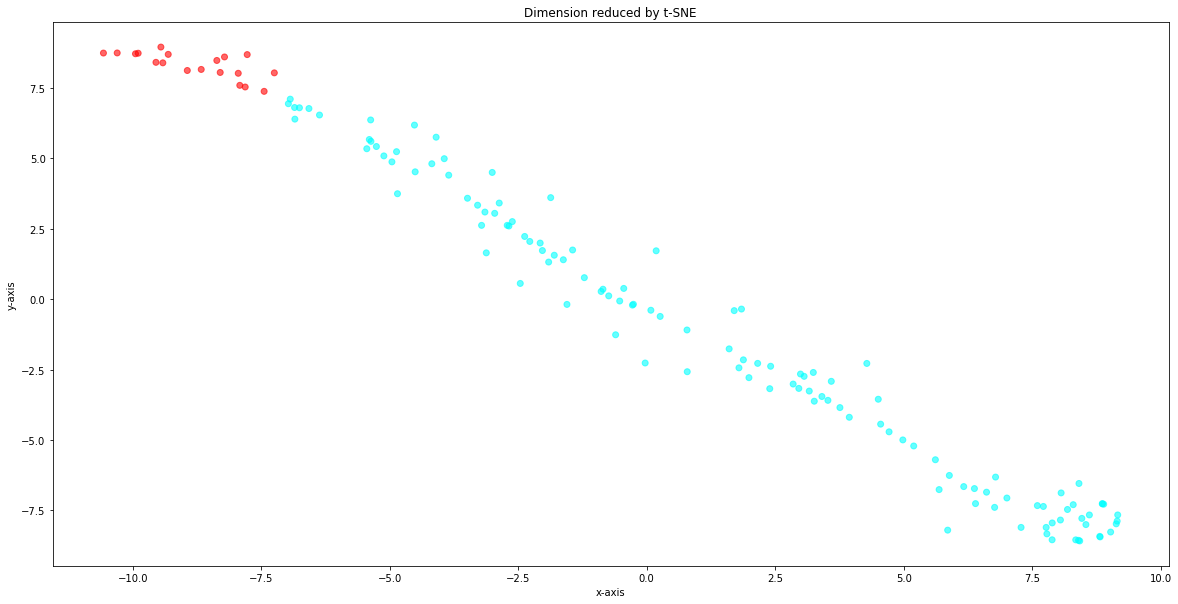

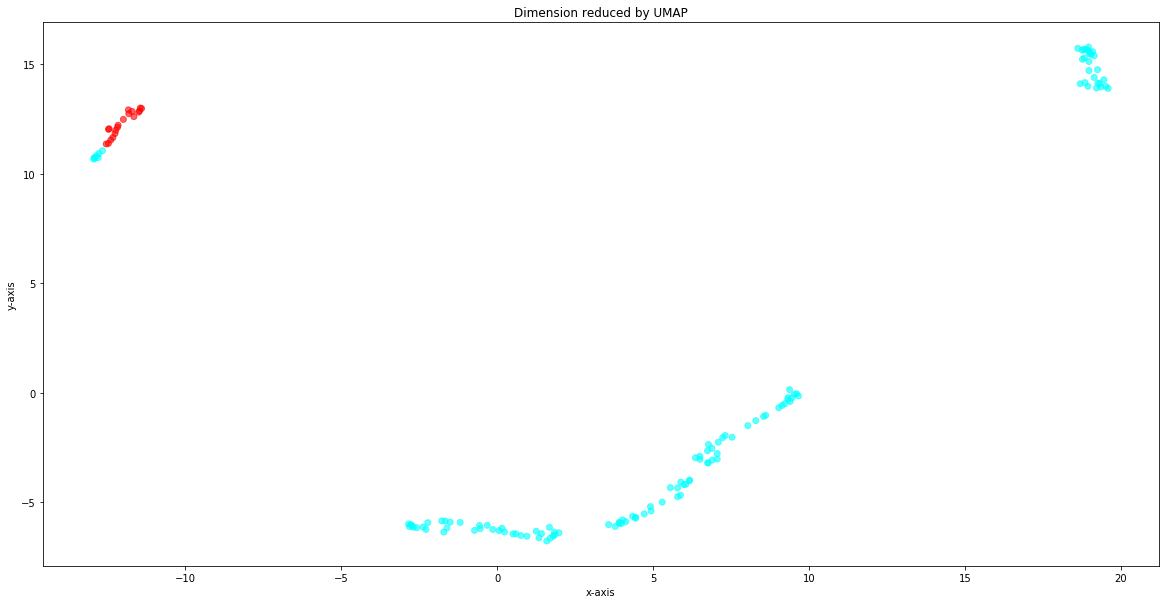

In [213]:
performAgglomerativeClustering(ncl=2, X=pivot.values, pivot=pivot)

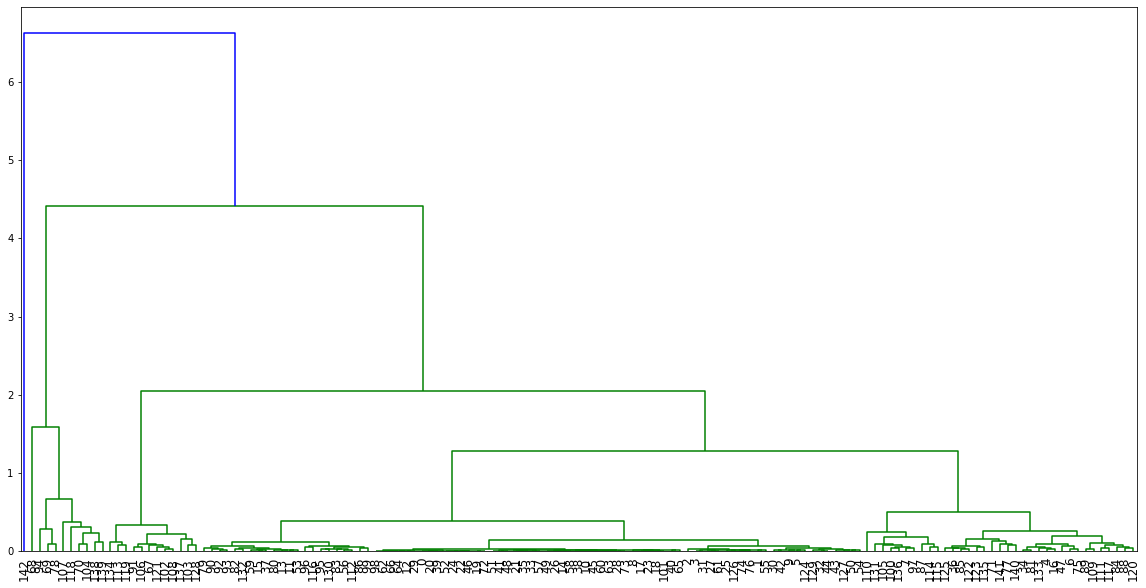

In [214]:
pivot = generate_quarter_pivot_matrix(4,aggTrain)
plot_scipy_edndogram(pivot = pivot)


silhouette sample on euclidean metric:  [0.8904658  0.89503769 0.89321591 0.89654895 0.86433132 0.89728942
 0.86989893 0.71186215 0.8933923  0.89705035 0.89184674 0.89301582
 0.88891842 0.893569   0.89215661 0.89440046 0.86651314 0.89258446
 0.89259886 0.88949919 0.89033703 0.89379033 0.89036522 0.89318053
 0.89025612 0.89471583 0.89279311 0.8968228  0.89128642 0.88891842
 0.8965196  0.8965491  0.89709813 0.89284775 0.86009124 0.89396482
 0.82840766 0.89529781 0.89222223 0.89040661 0.89126091 0.89434319
 0.89671151 0.89693325 0.89699359 0.892049   0.89061716 0.85205046
 0.8940012  0.89147926 0.8969386  0.8936537  0.89054618 0.89220289
 0.89740356 0.89495793 0.88381183 0.8933029  0.89243139 0.89612644
 0.89083754 0.89635517 0.88893328 0.89110539 0.88891842 0.8929572
 0.88891842 0.55661237 0.42893319 0.6545415  0.47343259 0.76601038
 0.88981237 0.89137248 0.89530295 0.87212346 0.89583452 0.82076639
 0.66462633 0.89234869 0.89067455 0.8574051  0.88712364 0.88505478
 0.86010332 0.81491486 

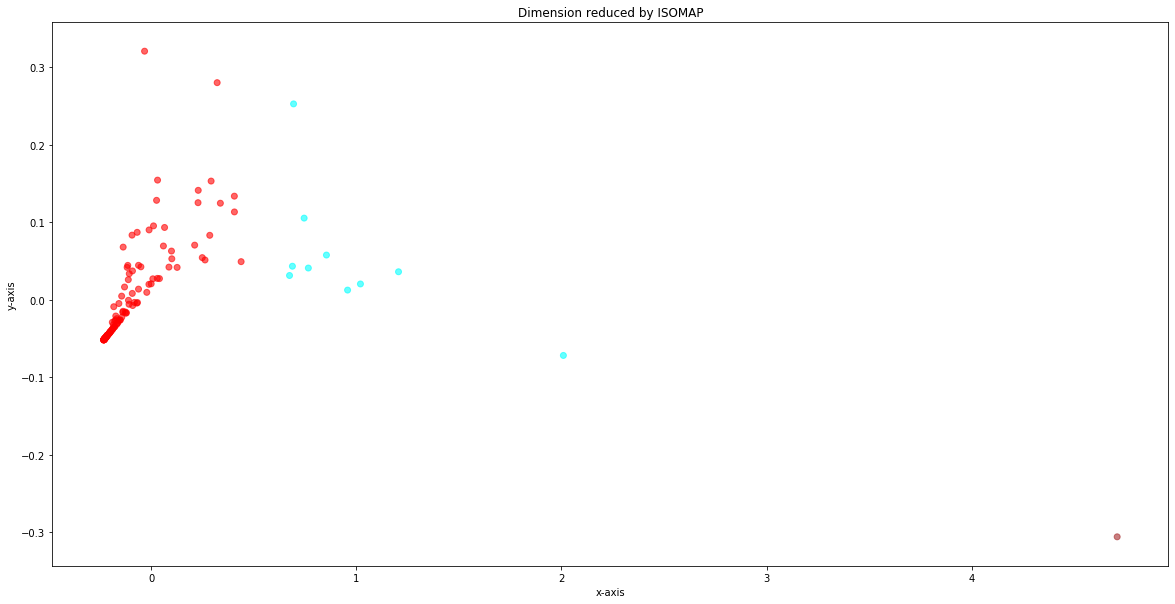

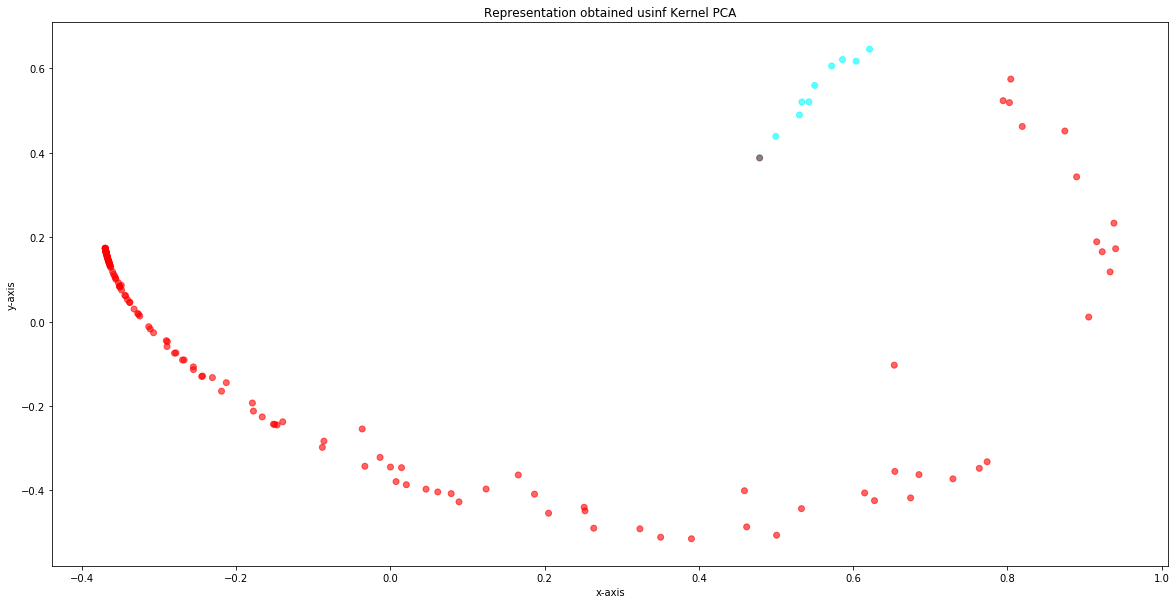

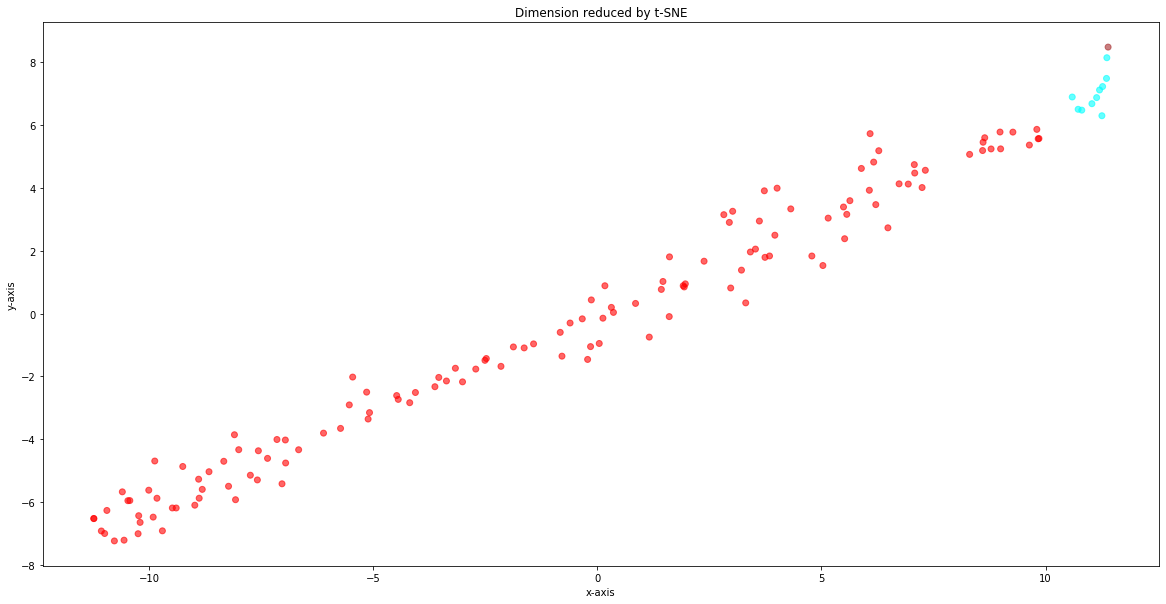

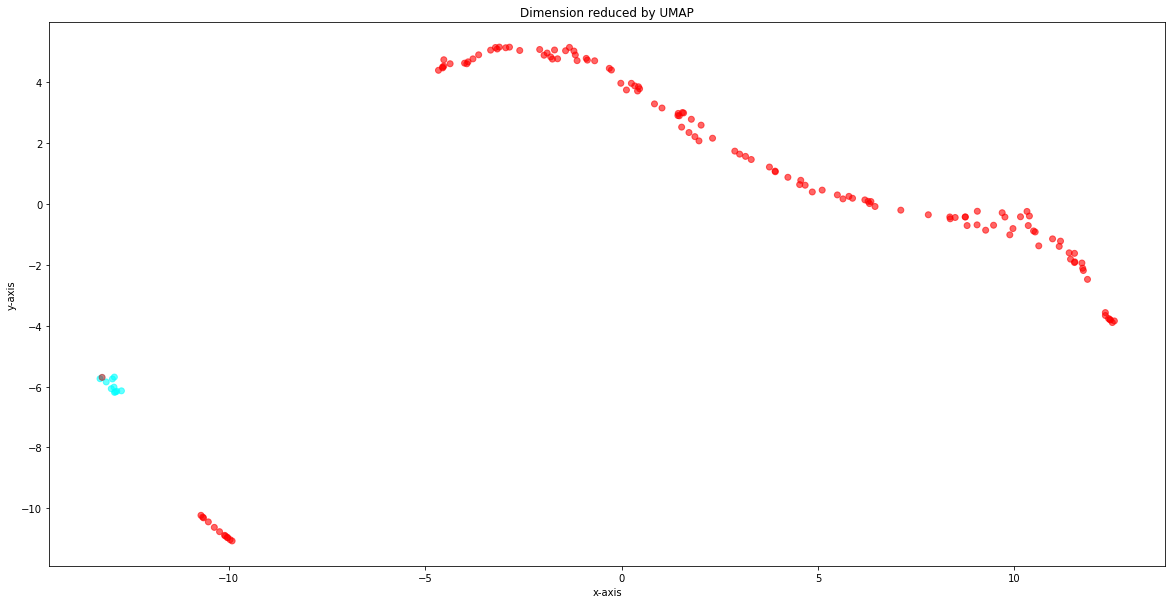

In [215]:
p = performAgglomerativeClustering(ncl=3, X=pivot.values, pivot=pivot)

In [216]:
p[p.index.get_level_values("cluster") ==1 ]

,hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
building_id,cluster,,,,,,,,,,,,,,,,,,,,,
1331,1,6668.212921,6869.022135,6927.357303,6955.535955,7044.101573,7112.364607,7138.99809,7630.422921,7794.316292,7245.76236,...,6562.167539,6646.147022,6901.039618,7345.286292,7642.204157,8019.761685,8106.188202,7271.644157,6933.24573,6701.097416


In [ ]:
dtwMatrix = generate_quarter_pivot_matrix(0, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix = generate_dtw_matrix(dtwMatrix.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix)

pivot generated


In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix, pivot=generate_quarter_pivot_matrix(0, aggTrain))b

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]

In [ ]:
dtwMatrix = generate_quarter_pivot_matrix(1, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix = generate_dtw_matrix(dtwMatrix.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix)

In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix, pivot=generate_quarter_pivot_matrix(0, aggTrain))b

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]

In [ ]:
dtwMatrix = generate_quarter_pivot_matrix(4, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix = generate_dtw_matrix(dtwMatrix.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix)

In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix, pivot=generate_quarter_pivot_matrix(0, aggTrain))b

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]

In [ ]:
dtwMatrix = generate_quarter_pivot_matrix(2, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix = generate_dtw_matrix(dtwMatrix.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix)

In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix, pivot=generate_quarter_pivot_matrix(0, aggTrain))b

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]

In [ ]:
dtwMatrix = generate_quarter_pivot_matrix(3, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix = generate_dtw_matrix(dtwMatrix.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix)

In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix, pivot=generate_quarter_pivot_matrix(0, aggTrain))b

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]

In [ ]:
dtwMatrix = generate_quarter_pivot_matrix(4, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix = generate_dtw_matrix(dtwMatrix.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix)

In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix, pivot=generate_quarter_pivot_matrix(0, aggTrain))b

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]